# **Классификация музыкальных жанров**

# 1. Описание задачи. Описание данных.



**Задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.**

**Данные:**


* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Задача - предсказать значение 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - целевой признак.

**Описание данных:**

- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- music_genre - музыкальный жанр




# 2. Подготовка данных. Загрузка и изучение данных. Первоначальное EDA.

## Загрузка библиотек. Загрузка и изучение данных

---



**Загружаем библиотеки, считываем CSV-файлы с данными с помощью библиотеки Pandas и сохраняем их в датафреймы, делаем копии для работы над гипотезами.**

In [1348]:
!pip install imblearn -q

In [1349]:
!pip install catboost -q

In [1350]:
!pip install optuna -q

In [1351]:
!pip install phik -q

In [1352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import fbeta_score

from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import phik
from phik.report import plot_correlation_matrix
from phik import report

import os

**Загрузка данных:**

**Загрузка** / **Colaboratory**

In [1353]:
DATA_PATH = '/content/'
RANDOM_STATE = 12345

In [1354]:
data_train1 = pd.read_csv(os.path.join(DATA_PATH, 'kaggle_music_genre_train.csv'))

[Ссылка на датасет / Kaggle](https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre?datasetId=1690118&sortBy=voteCount&select=music_genre.csv)

In [1355]:
data_train2 = pd.read_csv(os.path.join(DATA_PATH, 'music_genre.csv'))

In [1356]:
data_test = pd.read_csv(os.path.join(DATA_PATH, 'kaggle_music_genre_test.csv'))

In [1357]:
sample_submit = pd.read_csv(os.path.join(DATA_PATH, 'sample_submit.csv'))

In [1358]:
data_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [1359]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


In [1360]:
data_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [1361]:
data_train1 = data_train1.drop(['instance_id', 'obtained_date', 'track_name'], axis=1)

In [1362]:
data_test = data_test.drop(['instance_id', 'obtained_date', 'track_name'], axis=1)

In [1363]:
data_train2 = data_train2.drop(['instance_id', 'artist_name', 'obtained_date', 'popularity', 'track_name'], axis=1)

**Соединяем два датасета в один - обучающий.**

In [1364]:
data = pd.concat([data_train1, data_train2])

**Делаем копии для проверки наших гипотез - по заполнению пропущенных значений.**

In [1365]:
data_train_hypothesis_2 = data.copy()
data_test_hypothesis_2 = data_test.copy()

In [1366]:
data_train_hypothesis_3 = data.copy()
data_test_hypothesis_3 = data_test.copy()

**Изучение общей информации.**

In [1367]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70399 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70394 non-null  float64
 1   danceability      70394 non-null  float64
 2   duration_ms       70394 non-null  float64
 3   energy            70394 non-null  float64
 4   instrumentalness  70394 non-null  float64
 5   key               69659 non-null  object 
 6   liveness          70394 non-null  float64
 7   loudness          70394 non-null  float64
 8   mode              69888 non-null  object 
 9   speechiness       70394 non-null  float64
 10  tempo             69952 non-null  object 
 11  valence           70394 non-null  float64
 12  music_genre       70394 non-null  object 
dtypes: float64(9), object(4)
memory usage: 7.5+ MB


In [1368]:
data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,70394.000000,70394.000000,7.039400e+04,70394.000000,70394.000000,70394.000000,70394.000000,70394.000000,70394.000000
mean,0.297228,0.559325,2.209985e+05,0.607149,0.175339,0.195242,-8.965507,0.092939,0.458676
std,0.336056,0.176714,1.281116e+05,0.261025,0.320195,0.163145,5.984224,0.100337,0.246071
min,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,0.018400,0.445000,1.757070e+05,0.444000,0.000000,0.097000,-10.660750,0.036000,0.262000
50%,0.137000,0.569000,2.193600e+05,0.650000,0.000154,0.127000,-7.214000,0.048900,0.451000
75%,0.526000,0.686000,2.679330e+05,0.820000,0.130750,0.246000,-5.134000,0.097700,0.650000
max,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


**В обучающем наборе обнаружено 70394 строк и 13 столбцов.**

### **Первоначальное EDA**

#### Самая популярная тональность

In [1369]:
popular_key  = data.groupby(['key',  'mode']).agg({'key': 'count',
                                                         'mode': 'count'})
popular_key

key  mode
key mode             
A   Major  4171  4171
    Minor  2616  2616
A#  Major  2133  2133
    Minor  2416  2416
B   Major  2322  2322
    Minor  2951  2951
C   Major  5979  5979
    Minor  1643  1643
C#  Major  5391  5391
    Minor  2080  2080
D   Major  5765  5765
    Minor  1569  1569
D#  Major  1404  1404
    Minor   780   780
E   Major  2391  2391
    Minor  2850  2850
F   Major  3179  3179
    Minor  2733  2733
F#  Major  2241  2241
    Minor  2031  2031
G   Major  6048  6048
    Minor  1920  1920
G#  Major  3456  3456
    Minor  1106  1106

In [1370]:
popular_key.max()

,0
key,6048
mode,6048


In [1371]:
popular_key.loc[(popular_key['key'] == 6048)]

,,key,mode
key,mode,,
G,Major,6048,6048


**Самая популярная тональность в датасете - соль мажор. Данные о самой популярной тональности понадобятся нам для заполнения пропусков в тестовой выборке в первой гипотезе.**

#### Продолжительность треков

**Обнаружены аномальные значения в столбце `duration_ms`.**

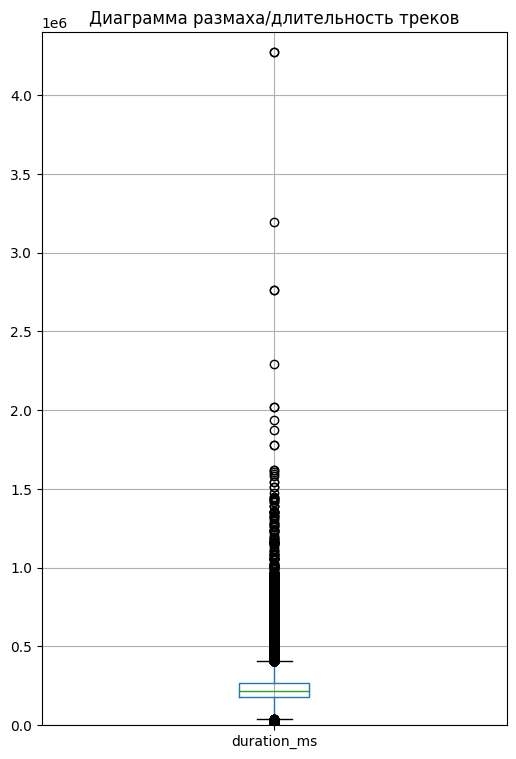

In [1372]:
data.boxplot(column='duration_ms', figsize=(6,9))
plt.ylim(-100, 4400000)
plt.title('Диаграмма размаха/длительность треков')
plt.show()

In [1373]:
data['duration_ms'].max()

4830606.0

In [1374]:
data.loc[data['duration_ms'] >= 4400000]
#это целый компакт-диск

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
20117,0.52800,0.408,4497994.0,0.436,0.0995,E,0.198,-11.497,Minor,0.164,76.868,0.0778,Electronic
1410,0.00164,0.467,4830606.0,0.948,0.0103,C#,0.405,-1.929,Major,0.299,?,0.3170,Electronic
2133,0.52800,0.408,4497994.0,0.436,0.0995,E,0.198,-11.497,Minor,0.164,76.868,0.0778,Electronic


#### Самые длинные треки

In [1375]:
data_long = data.loc[data['duration_ms'] >= 600000]

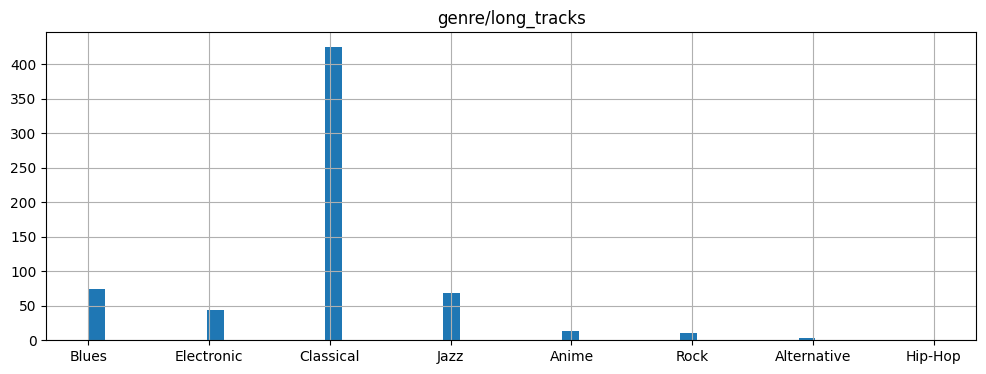

In [1376]:
data_long['music_genre'].hist(bins=50, figsize=(12,4))
plt.title('genre/long_tracks')
plt.show()

In [1377]:
data_live_cd = data_long.loc[data_long['duration_ms'] >= 1800000]
data_live_cd.head()
#больше 30 минут

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
4502,0.00299,0.366,4276000.0,0.778,0.0697,D,0.0954,-4.126,Major,0.0622,138.293,0.1470,Electronic
8222,0.13800,0.478,2764934.0,0.897,0.6570,G,0.1000,-6.554,Major,0.0471,113.018,0.1860,Electronic
10699,0.12300,0.332,2019293.0,0.741,0.7050,F#,0.9420,-10.472,Minor,0.0535,NaN,0.2590,Blues
20117,0.52800,0.408,4497994.0,0.436,0.0995,E,0.1980,-11.497,Minor,0.1640,76.868,0.0778,Electronic
1410,0.00164,0.467,4830606.0,0.948,0.0103,C#,0.4050,-1.929,Major,0.2990,?,0.3170,Electronic


**Самые длинные треки чаще всего встречаются в жанре - классическая музыка. Треки дольше 30 минут встречаются в жанрах - электронная музыка и блюз.**

#### Самые короткие треки

In [1378]:
data_min = data.loc[data['duration_ms'] <= 60000]
data_min.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
13,0.1100,0.470,-1.0,0.6410,0.000,F#,0.155,-7.454,Major,0.0658,86.387,0.6380,Anime
26,0.9910,0.154,-1.0,0.0384,0.902,NaN,0.109,-26.909,Major,0.0405,68.199,0.0393,Classical
35,0.0848,0.748,-1.0,0.7120,0.000,D,0.132,-5.651,Major,0.1430,140.055,0.1800,Rap


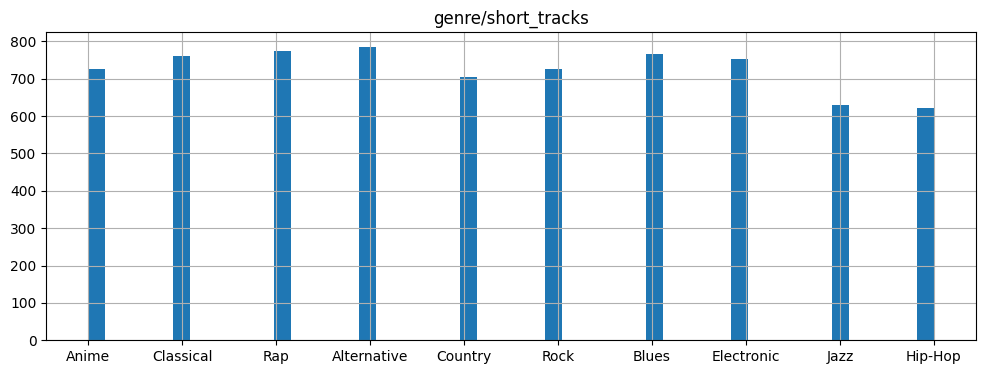

In [1379]:
data_min['music_genre'].hist(bins=50, figsize=(12,4))
plt.title('genre/short_tracks')
plt.show()

Самые короткие треки встречаются в таких жанрах, как рэп и  альтернативная музыка.

### Аномальные значения

In [1380]:
data['duration_ms'].median()
#в среднем трек длится 3 минуты 65 секунд

219360.0

Избавимся от аномальных значений.

In [1381]:
data = data.query('duration_ms > 0')

In [1382]:
data_train_gip_2 = data_train_hypothesis_2.query('duration_ms > 0')

In [1383]:
data_train_gip_3 = data_train_hypothesis_3.query('duration_ms > 0')

In [1384]:
data['duration_ms'].min()

15509.0

In [1385]:
data_min_25 = data.loc[data['duration_ms'] <= 15509]
data_min_25.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
4036,0.969,0.562,15509.0,0.125,0.00138,B,0.373,-15.449,Minor,0.201,115.827,0.574,Classical
40036,0.969,0.562,15509.0,0.125,0.00138,B,0.373,-15.449,Minor,0.201,115.82700000000001,0.574,Classical


**Минимальная продолжительность звучания трека равна 25 секундам.**

## Проверка на наличие в датафреймах пропущенных значений и дубликатов.

In [1386]:
data.isna().sum()

,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,666
liveness,0
loudness,0
mode,447
speechiness,0


In [1387]:
data_test.isna().sum()

,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,158
liveness,0
loudness,0
mode,149
speechiness,0


In [1388]:
data.duplicated().sum()

40

In [1389]:
data_train_hypothesis_2.duplicated().sum()

44

In [1390]:
data_train_hypothesis_3.duplicated().sum()

44

In [1391]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [1392]:
data_train_hypothesis_2 = data_train_hypothesis_2.drop_duplicates().reset_index(drop=True)
data_train_hypothesis_2.duplicated().sum()

0

In [1393]:
data_train_hypothesis_3 = data_train_hypothesis_3.drop_duplicates().reset_index(drop=True)
data_train_hypothesis_3.duplicated().sum()

0

Обнаружен знак вопроса '?' в строке признака `tempo`.

In [1394]:
data['tempo'] = data['tempo'].replace('?', 1)

In [1395]:
data_train_hypothesis_2['tempo'] = data_train_hypothesis_2['tempo'].replace('?', 1)

In [1396]:
data_train_hypothesis_3['tempo'] = data_train_hypothesis_3['tempo'].replace('?', 1)

In [1397]:
data['tempo'] = data['tempo'].astype('float64')

In [1398]:
data_test['tempo'] = data_test['tempo'].astype('float64')

In [1399]:
data_train_hypothesis_2['tempo'] = data_train_hypothesis_2['tempo'].astype('float64')

In [1400]:
data_test_hypothesis_2['tempo'] = data_test_hypothesis_2['tempo'].astype('float64')

In [1401]:
data_train_hypothesis_3['tempo'] = data_train_hypothesis_3['tempo'].astype('float64')

In [1402]:
data_test_hypothesis_3['tempo'] = data_test_hypothesis_3['tempo'].astype('float64')

In [1403]:
data_test_hypothesis_3.dtypes

,0
acousticness,float64
danceability,float64
duration_ms,float64
energy,float64
instrumentalness,float64
key,object
liveness,float64
loudness,float64
mode,object
speechiness,float64


### **Гипотеза №1. Заполнение пропусков в обучающем наборе данных медианой. Заполнение пропусков в тестовом наборе данных медианой. Предобработка данных.**

**Мы рассматриваем первую гипотезу - для обучения модели используем определённую предобработку данных - заполнение пропусков в тестовом наборе медианными значениями по группе, в которой обнаружены данные пропуски (по обучающей выборке) и заполнение пропусков медианными значениями в тестовой выборке.**

In [1404]:
data['mode'] = data['mode'].fillna('unknown_mode')
data['key'] = data['key'].fillna('unknown_key')
data['tempo'] = data['tempo'].fillna(data['tempo'].median())


data_test['mode'] = data_test['mode'].fillna('unknown_mode')
data_test['key'] = data_test['key'].fillna('unknown_key')
data_test['tempo'] = data_test['tempo'].fillna(data_test['tempo'].median())

In [1405]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      5099 non-null   float64
 1   danceability      5099 non-null   float64
 2   duration_ms       5099 non-null   float64
 3   energy            5099 non-null   float64
 4   instrumentalness  5099 non-null   float64
 5   key               5099 non-null   object 
 6   liveness          5099 non-null   float64
 7   loudness          5099 non-null   float64
 8   mode              5099 non-null   object 
 9   speechiness       5099 non-null   float64
 10  tempo             5099 non-null   float64
 11  valence           5099 non-null   float64
dtypes: float64(10), object(2)
memory usage: 478.2+ KB


### **Гипотеза 2. Удаление пропущенных значений**

**Следующая наша гипотеза состоит в том, что мы удаляем все строки с пропущенными значениями из выборок.**

In [1406]:
data_train_hypothesis_2 = data_train_hypothesis_2.dropna(subset=['key','mode','tempo']).reset_index(drop=True)

In [1407]:
data_test_hypothesis_2 = data_test_hypothesis_2.dropna(subset=['key','mode','tempo']).reset_index(drop=True)

# **EDA**

## Жанры

In [1408]:
data['music_genre'].unique()

array(['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Rap', 'Classical', 'Anime'], dtype=object)

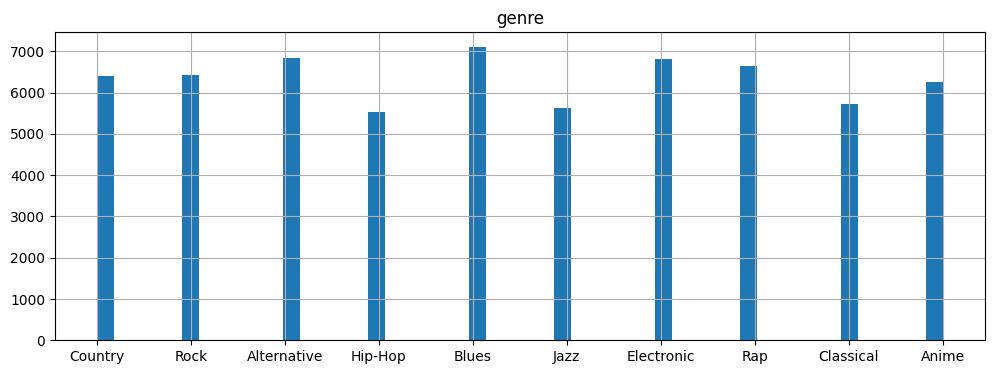

In [1409]:
data['music_genre'].hist(bins=50, figsize=(12,4))
plt.title('genre')
plt.show()

**Наиболее часто встречаемые треки в обучающем наборе данных принадлежат жанрам - блюз, альтернативная музыка и электронная музыка.**

**1. Electronic**

In [1410]:
data_electr = (data.loc[(data['music_genre'] == 'Electronic')])
data_electr.head(2)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
9,0.0323,0.537,237000.0,0.962,0.193000,C,0.158,-2.749,Major,0.121,160.031,0.430,Electronic
15,0.0251,0.485,248471.0,0.842,0.000806,A,0.307,-6.617,Major,0.266,141.873,0.193,Electronic


In [1411]:
data_electr.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,6822.000000,6822.000000,6.822000e+03,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000
mean,0.121934,0.619407,2.705229e+05,0.738597,0.349245,0.209822,-7.023723,0.099321,116.980039,0.391337
std,0.201451,0.148169,1.551210e+05,0.188793,0.362885,0.176087,3.668904,0.099619,40.953675,0.239440
min,0.000002,0.082200,3.405900e+04,0.021100,0.000000,0.017300,-25.582000,0.023400,1.000000,0.020500
25%,0.003990,0.529000,2.068035e+05,0.610250,0.003120,0.095400,-9.260750,0.040200,101.012000,0.191000
50%,0.026200,0.631000,2.447465e+05,0.773000,0.182000,0.128000,-6.429000,0.057700,123.992000,0.361000
75%,0.139750,0.725000,3.095620e+05,0.899000,0.754000,0.287750,-4.373500,0.110000,142.019250,0.560750
max,0.985000,0.979000,4.830606e+06,0.999000,0.986000,0.984000,1.585000,0.774000,218.030000,0.992000


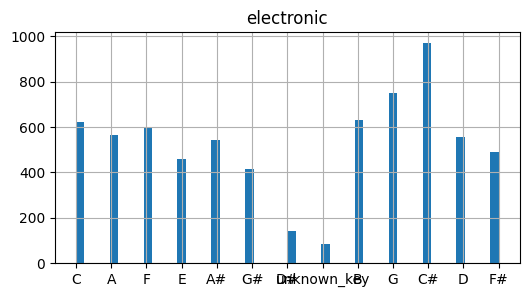

In [1412]:
data_electr['key'].hist(bins=50, figsize=(6,3))
plt.title('electronic')
plt.show()

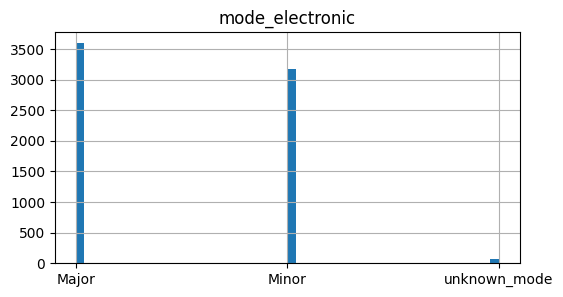

In [1413]:
data_electr['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_electronic')
plt.show()

In [1414]:
data_electr['tempo'].describe()

,tempo
count,6822.000000
mean,116.980039
std,40.953675
min,1.000000
25%,101.012000
50%,123.992000
75%,142.019250
max,218.030000


**Электронная музыка. Медианный темп - 121.**
**Она достаточно громкая и не очень акустичная, в ней мало речи, она танцевальная и энергичная, но не очень радостная (небольшое медианное значение `valence`). Чаще всего встречаются тональности с тоникой до диез, преобладают мажорные тональности.**

**Популярные тональности в разных жанрах:**

In [1415]:
popular_key_genre  = data.groupby(['key',  'mode', 'music_genre']).agg({'key': 'count',
                                                         'mode': 'count'})

In [1416]:
popular_key_genre.describe()

,key,mode
count,375.000000,375.000000
mean,169.082667,169.082667
std,181.193005,181.193005
min,1.000000,1.000000
25%,6.000000,6.000000
50%,133.000000,133.000000
75%,262.000000,262.000000
max,869.000000,869.000000


In [1417]:
popular_key_genre_max = popular_key_genre.loc[popular_key_genre['key'] == 306]
popular_key_genre_max.head()

,,,key,mode
key,mode,music_genre,,


In [1418]:
popular_key_genre_min = popular_key_genre.loc[popular_key_genre['key'] == 5]
popular_key_genre_min.head()

key  mode
key mode         music_genre           
A#  unknown_mode Electronic     5     5
C   unknown_mode Rap            5     5
                 Rock           5     5
C#  unknown_mode Alternative    5     5
                 Anime          5     5

**Самая популярная тональность это ре мажор в хип-хопе. А самая непопулярные тональности с тоникой до диез в альтернативе и аниме.**

**2. Country**

In [1419]:
data_country = (data.loc[(data['music_genre'] == 'Country')])

In [1420]:
data_country.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000
mean,0.272652,0.577538,216981.460471,0.637202,0.005653,0.185905,-7.329474,0.049287,114.944934,0.538113
std,0.261843,0.109452,44533.957545,0.200329,0.043170,0.151836,3.240954,0.049624,42.839240,0.221329
min,0.000028,0.203000,56227.000000,0.021000,0.000000,0.021200,-27.119000,0.022300,1.000000,0.040400
25%,0.049500,0.509000,188723.000000,0.493000,0.000000,0.098500,-8.839000,0.029500,94.011000,0.361000
50%,0.186000,0.580000,211640.000000,0.669000,0.000001,0.129000,-6.537000,0.034500,119.967000,0.528000
75%,0.440000,0.648000,237373.000000,0.802000,0.000042,0.227000,-5.027000,0.045500,143.460000,0.718000
max,0.981000,0.953000,599315.000000,0.991000,0.880000,0.984000,-0.521000,0.689000,217.538000,0.977000


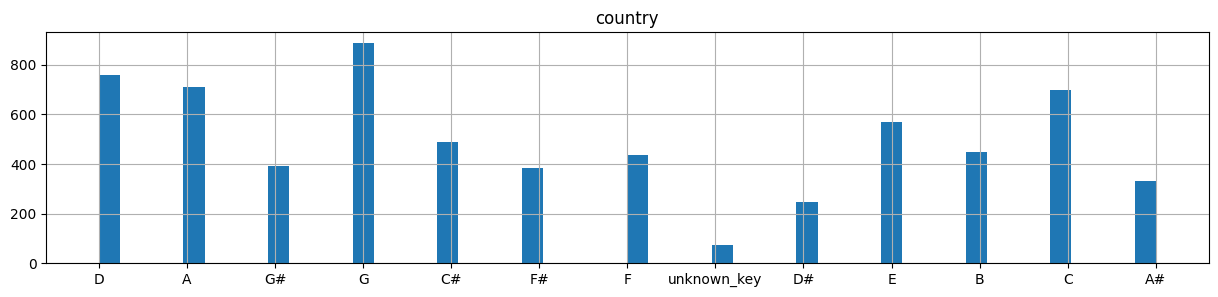

In [1421]:
data_country['key'].hist(bins=50, figsize=(15,3))
plt.title('country')
plt.show()

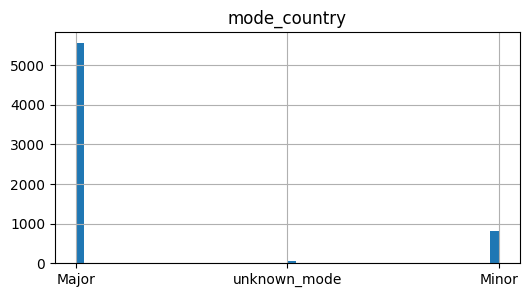

In [1422]:
data_country['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_country')
plt.show()

In [1423]:
data_country['tempo'].describe()

,tempo
count,6413.000000
mean,114.944934
std,42.839240
min,1.000000
25%,94.011000
50%,119.967000
75%,143.460000
max,217.538000


In [1424]:
data_country['energy'].describe()

,energy
count,6413.000000
mean,0.637202
std,0.200329
min,0.021000
25%,0.493000
50%,0.669000
75%,0.802000
max,0.991000


**Жанр `country`. Медианный темп - 117.**
**Чаще всего встречаются тональности с тоникой соль, преобладают мажорные тональности.**

**3. Rock**

In [1425]:
data_rock = (data.loc[(data['music_genre'] == 'Rock')])

In [1426]:
data_rock.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,6438.000000,6438.000000,6438.000000,6438.000000,6438.000000,6438.000000,6438.000000,6438.000000,6438.000000,6438.000000
mean,0.192755,0.539619,237552.292948,0.686835,0.056536,0.187471,-7.266366,0.053369,115.104707,0.522119
std,0.250615,0.134097,65377.668909,0.202119,0.170124,0.150922,3.337282,0.041150,40.423405,0.234053
min,0.000001,0.064500,55253.000000,0.002590,0.000000,0.015700,-37.124000,0.022400,1.000000,0.027700
25%,0.008370,0.452000,198053.250000,0.549000,0.000000,0.093800,-9.078250,0.031800,95.510500,0.339250
50%,0.069900,0.547000,225753.500000,0.722000,0.000048,0.127000,-6.466500,0.039200,118.552000,0.520000
75%,0.298000,0.633000,264086.500000,0.854000,0.005310,0.240000,-4.855000,0.056300,140.186500,0.706000
max,0.994000,0.920000,811077.000000,0.998000,0.974000,0.979000,1.023000,0.539000,219.331000,0.985000


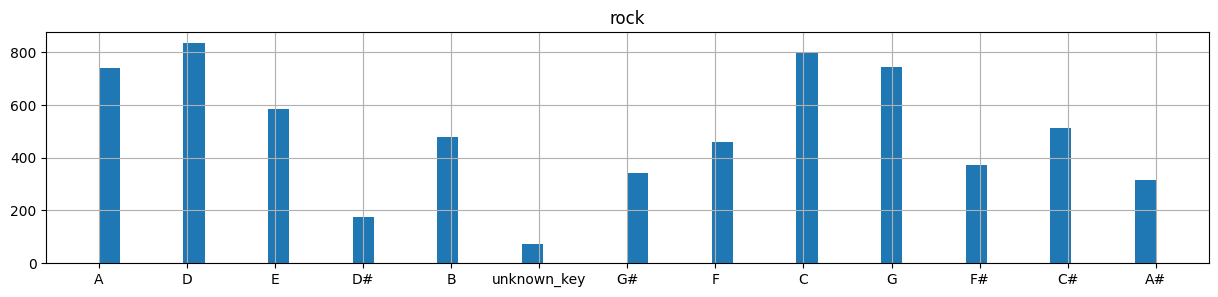

In [1427]:
data_rock['key'].hist(bins=50, figsize=(15,3))
plt.title('rock')
plt.show()

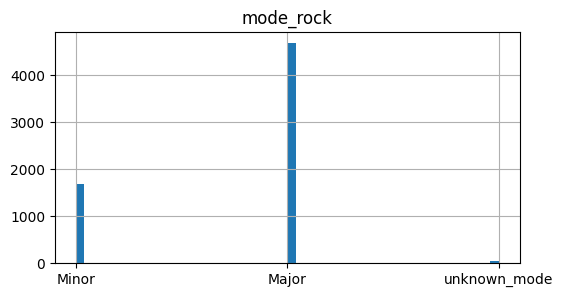

In [1428]:
data_rock['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_rock')
plt.show()

In [1429]:
data_rock['tempo'].describe()

,tempo
count,6438.000000
mean,115.104707
std,40.423405
min,1.000000
25%,95.510500
50%,118.552000
75%,140.186500
max,219.331000


**Жанр `rock`. Медианный темп - 116.**
**Чаще всего встречаются тональности с тоникой ре, преобладают мажорные тональности.**

**4. Jazz**

In [1430]:
data_jazz = (data.loc[(data['music_genre'] == 'Jazz')])

In [1431]:
data_jazz.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5624.000000,5624.000000,5.624000e+03,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000,5624.000000
mean,0.493886,0.583218,2.652001e+05,0.474262,0.354267,0.172164,-11.199922,0.072986,102.868908,0.506275
std,0.340903,0.160183,1.145168e+05,0.239563,0.382814,0.145358,4.636053,0.079790,40.907287,0.250105
min,0.000002,0.059600,1.969300e+04,0.002110,0.000000,0.023700,-35.200000,0.022600,1.000000,0.028900
25%,0.151000,0.470000,1.902235e+05,0.288000,0.000188,0.094600,-13.653500,0.035200,86.186750,0.295000
50%,0.509500,0.598000,2.477970e+05,0.476500,0.122500,0.116000,-10.335000,0.043700,101.678000,0.513000
75%,0.823250,0.703000,3.143202e+05,0.657000,0.795000,0.184000,-7.880000,0.067600,125.006000,0.704000
max,0.996000,0.976000,1.352413e+06,0.997000,0.985000,0.986000,-1.002000,0.939000,213.038000,0.985000


In [1432]:
data_jazz['tempo'].describe()

,tempo
count,5624.000000
mean,102.868908
std,40.907287
min,1.000000
25%,86.186750
50%,101.678000
75%,125.006000
max,213.038000


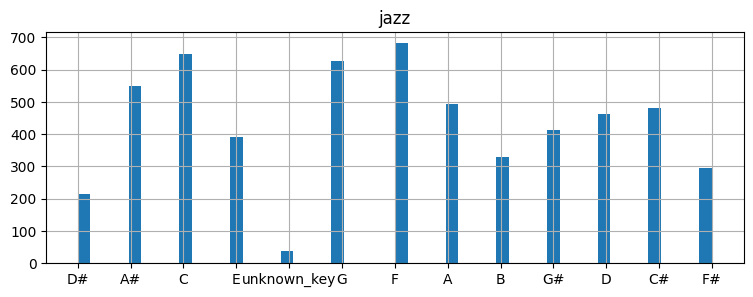

In [1433]:
data_jazz['key'].hist(bins=50, figsize=(9,3))
plt.title('jazz')
plt.show()

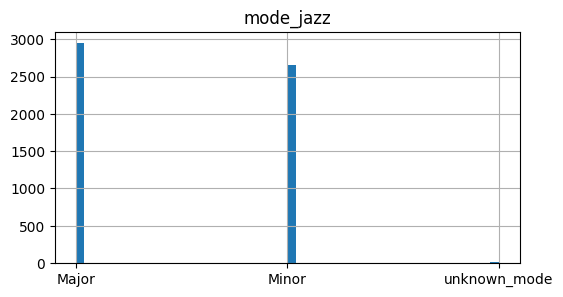

In [1434]:
data_jazz['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_jazz')
plt.show()

**Жанр `jazz`. Медианный темп - 101.**
**Чаще всего встречаются тональности с тониками фа, соль, до. Преобладают мажорные тональности.**

**5. Alternative**

In [1435]:
data_alt = (data.loc[(data['music_genre'] == 'Alternative')])

In [1436]:
data_alt.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,6841.000000,6841.000000,6841.000000,6841.000000,6841.000000,6841.000000,6841.000000,6841.00000,6841.000000,6841.000000
mean,0.164782,0.543806,233206.363982,0.712125,0.061245,0.196982,-6.511256,0.08890,114.344293,0.448300
std,0.243137,0.150519,60393.172291,0.206556,0.175182,0.154309,2.770042,0.09262,42.018721,0.216008
min,0.000001,0.061700,24000.000000,0.048400,0.000000,0.021200,-22.191000,0.02310,1.000000,0.034200
25%,0.001950,0.442000,197453.000000,0.559000,0.000000,0.099400,-7.957000,0.03610,92.966000,0.284000
50%,0.032900,0.541000,225691.000000,0.750000,0.000066,0.133000,-5.982000,0.05260,117.969000,0.432000
75%,0.242000,0.648000,259707.000000,0.891000,0.006940,0.257000,-4.491000,0.09690,141.971000,0.600000
max,0.992000,0.971000,675653.000000,0.997000,0.942000,0.996000,1.342000,0.94100,213.788000,0.983000


In [1437]:
data_alt['tempo'].describe()

,tempo
count,6841.000000
mean,114.344293
std,42.018721
min,1.000000
25%,92.966000
50%,117.969000
75%,141.971000
max,213.788000


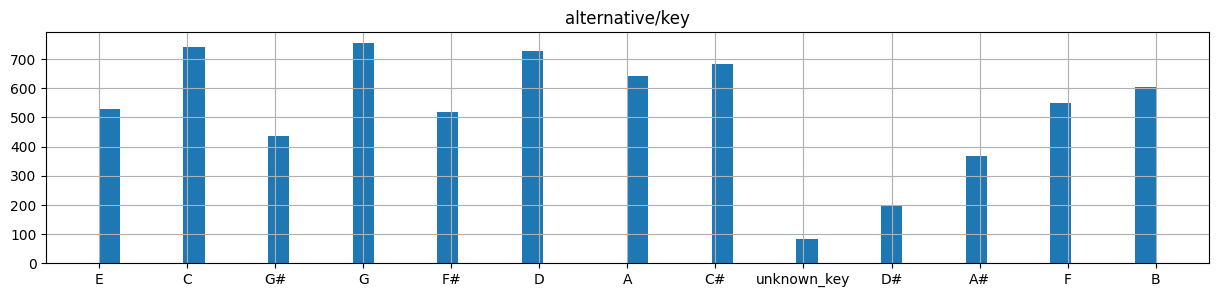

In [1438]:
data_alt['key'].hist(bins=50, figsize=(15,3))
plt.title('alternative/key')
plt.show()

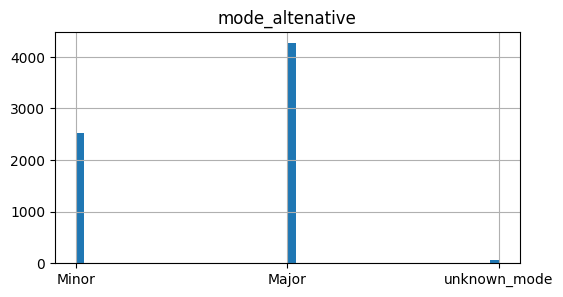

In [1439]:
data_alt['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_altenative')
plt.show()

**Жанр `alternative`. Медианный темп - 115.**
**Преобладают мажорные тональности. Чаще всего встречаются тональности с тониками - соль и до.**

**6. Hip-hop**

In [1440]:
data_hip_hop = (data.loc[(data['music_genre'] == 'Hip-Hop')])

In [1441]:
data_hip_hop.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000
mean,0.180779,0.717024,219327.333574,0.646795,0.010427,0.200925,-6.824844,0.207290,110.654063,0.477796
std,0.191898,0.131728,59362.990978,0.150830,0.072720,0.153570,2.467114,0.135814,43.033082,0.219919
min,0.000015,0.230000,33093.000000,0.095200,0.000000,0.019600,-25.602000,0.024600,1.000000,0.033600
25%,0.034600,0.638000,182264.750000,0.544000,0.000000,0.102000,-8.122750,0.086025,89.713750,0.305250
50%,0.108000,0.733000,214853.000000,0.651000,0.000000,0.136000,-6.490000,0.192000,115.958000,0.477500
75%,0.271000,0.815000,253030.000000,0.755000,0.000011,0.261000,-5.166750,0.299000,140.037500,0.646750
max,0.985000,0.986000,723573.000000,0.992000,0.927000,0.989000,1.012000,0.932000,213.788000,0.979000


In [1442]:
data_hip_hop['tempo'].describe()

,tempo
count,5534.000000
mean,110.654063
std,43.033082
min,1.000000
25%,89.713750
50%,115.958000
75%,140.037500
max,213.788000


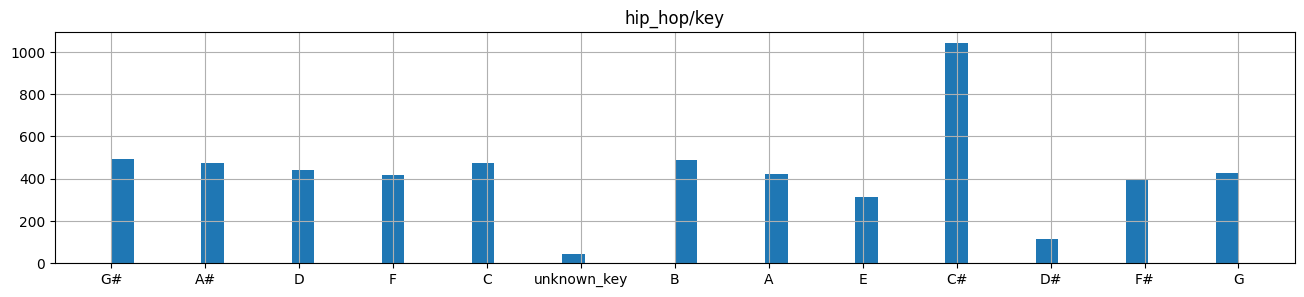

In [1443]:
data_hip_hop['key'].hist(bins=50, figsize=(16,3))
plt.title('hip_hop/key')
plt.show()

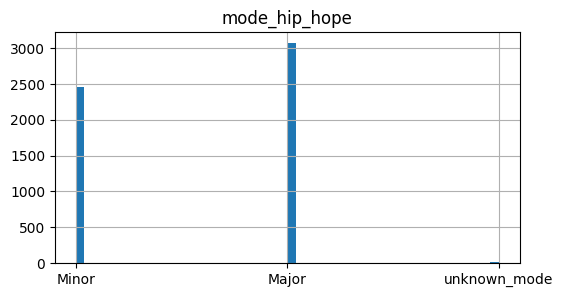

In [1444]:
data_hip_hop['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_hip_hope')
plt.show()

**Жанр `hip_hop`. Медианный темп - 114.**
**Преобладают мажорные тональности. Чаще всего встречаются тональности с тоникой - до диез.**

**7. Blues**

In [1445]:
data_blues = (data.loc[(data['music_genre'] == 'Blues')])

In [1446]:
data_blues.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,7106.000000,7106.000000,7.106000e+03,7106.000000,7106.000000,7106.000000,7106.000000,7106.000000,7106.000000,7106.000000
mean,0.313296,0.527746,2.534600e+05,0.613482,0.093197,0.234546,-8.956231,0.062246,113.281875,0.578525
std,0.304291,0.143691,1.130880e+05,0.227017,0.211875,0.221659,3.793099,0.061316,41.752131,0.223896
min,0.000002,0.118000,3.009700e+04,0.009570,0.000000,0.009670,-31.284000,0.023100,1.000000,0.031500
25%,0.037150,0.426000,1.864802e+05,0.449000,0.000009,0.098100,-11.273000,0.033900,93.725750,0.409000
50%,0.207000,0.529500,2.295870e+05,0.633000,0.000957,0.139000,-8.397000,0.043200,115.883500,0.586000
75%,0.548000,0.633000,2.872298e+05,0.806000,0.038000,0.290000,-6.145000,0.065800,138.487000,0.757000
max,0.996000,0.967000,2.019293e+06,0.998000,0.966000,1.000000,3.744000,0.942000,215.918000,0.985000


In [1447]:
data_blues['tempo'].describe()

,tempo
count,7106.000000
mean,113.281875
std,41.752131
min,1.000000
25%,93.725750
50%,115.883500
75%,138.487000
max,215.918000


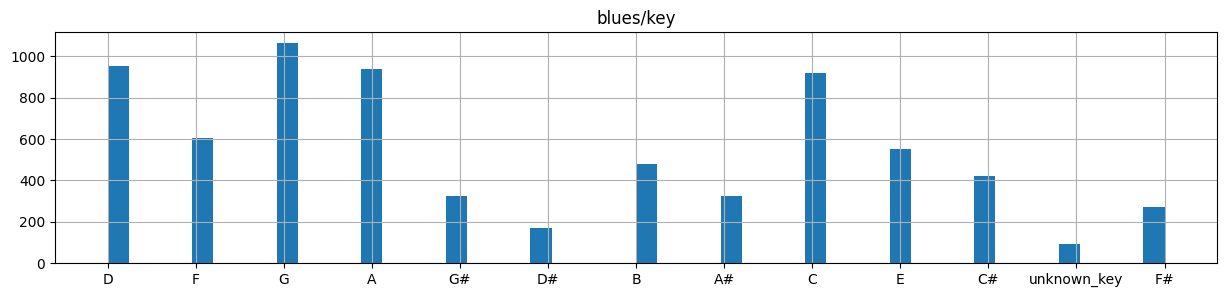

In [1448]:
data_blues['key'].hist(bins=50, figsize=(15,3))
plt.title('blues/key')
plt.show()

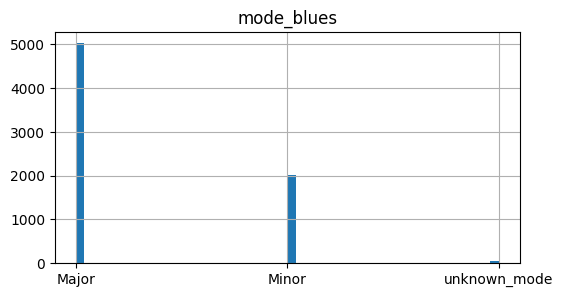

In [1449]:
data_blues['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_blues')
plt.show()

**Жанр `blues`. Медианный темп - 113.**
**Преобладают мажорные тональности. Чаще всего встречаются тональности с тоникой - соль.**

**8. Anime**

In [1450]:
data_anime = (data.loc[(data['music_genre'] == 'Anime')])

In [1451]:
data_anime.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,6254.000000,6254.000000,6.254000e+03,6254.000000,6254.000000,6254.000000,6254.000000,6254.000000,6254.000000,6254.000000
mean,0.279971,0.471495,2.307975e+05,0.668832,0.274665,0.192567,-7.893992,0.064419,117.270374,0.436766
std,0.358862,0.149294,8.329583e+04,0.297664,0.389203,0.137969,6.179538,0.052939,45.581738,0.247515
min,0.000000,0.060600,3.002700e+04,0.000943,0.000000,0.016900,-41.234000,0.022900,1.000000,0.000000
25%,0.004790,0.378000,1.854495e+05,0.434000,0.000000,0.098725,-10.523500,0.034600,93.523000,0.234250
50%,0.061700,0.487500,2.390000e+05,0.785000,0.000346,0.137000,-5.663000,0.045100,124.049000,0.436000
75%,0.551750,0.579000,2.782498e+05,0.925000,0.753000,0.273000,-3.584000,0.070600,146.998000,0.628000
max,0.996000,0.888000,1.295600e+06,0.999000,0.996000,0.967000,1.893000,0.498000,220.276000,0.989000


In [1452]:
data_anime['tempo'].describe()

,tempo
count,6254.000000
mean,117.270374
std,45.581738
min,1.000000
25%,93.523000
50%,124.049000
75%,146.998000
max,220.276000


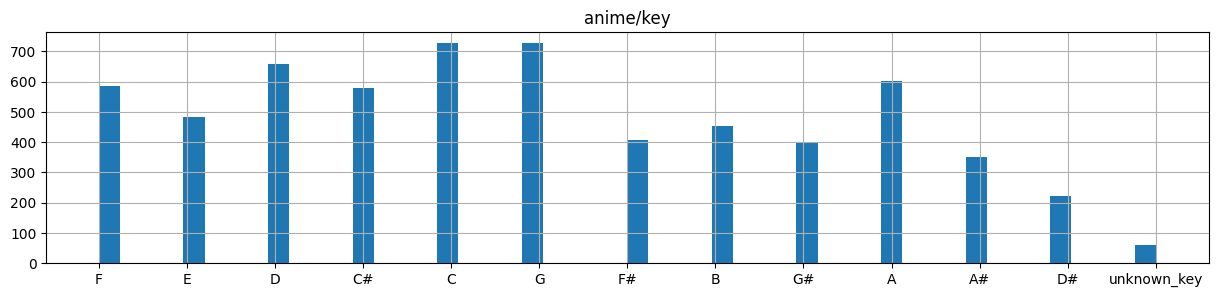

In [1453]:
data_anime['key'].hist(bins=50, figsize=(15,3))
plt.title('anime/key')
plt.show()

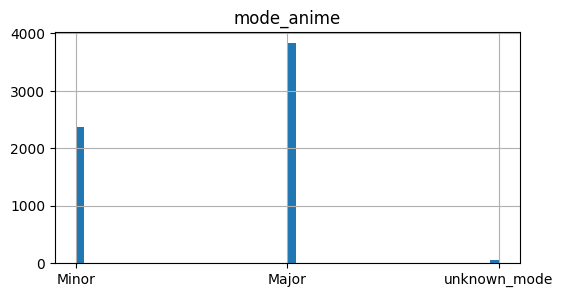

In [1454]:
data_anime['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_anime')
plt.show()

**Жанр `anime`. Медианный темп - 120.**
**Преобладают мажорные тональности. Чаще всего встречаются тональности с тониками - соль, до, ре.**

**9. Rap**

In [1455]:
data_rap = (data.loc[(data['music_genre'] == 'Rap')])

In [1456]:
data_rap.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000,6655.000000
mean,0.170165,0.696341,218908.197596,0.651694,0.008632,0.197508,-6.653347,0.187029,112.271245,0.456643
std,0.192347,0.139948,57157.550001,0.155323,0.063551,0.150503,2.406773,0.132200,41.071467,0.213361
min,0.000007,0.197000,59118.000000,0.147000,0.000000,0.020800,-20.188000,0.022900,1.000000,0.033600
25%,0.024400,0.603000,183420.000000,0.542000,0.000000,0.102000,-7.967000,0.070700,91.053000,0.291000
50%,0.095400,0.714000,214357.000000,0.649000,0.000000,0.135000,-6.344000,0.160000,117.957000,0.449000
75%,0.255000,0.801000,248719.000000,0.763000,0.000009,0.254000,-5.042000,0.279000,140.021500,0.614000
max,0.942000,0.977000,579293.000000,0.996000,0.922000,0.989000,-0.092000,0.922000,207.986000,0.970000


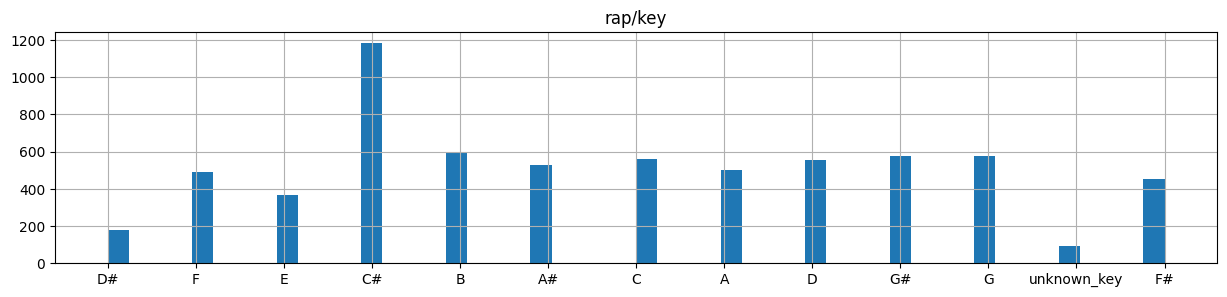

In [1457]:
data_rap['key'].hist(bins=50, figsize=(15,3))
plt.title('rap/key')
plt.show()

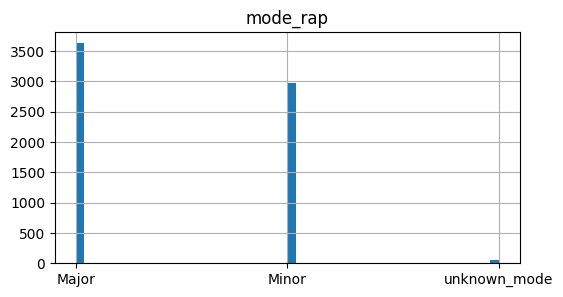

In [1458]:
data_rap['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_rap')
plt.show()

In [1459]:
data_rap['tempo'].describe()

,tempo
count,6655.000000
mean,112.271245
std,41.071467
min,1.000000
25%,91.053000
50%,117.957000
75%,140.021500
max,207.986000


**Жанр `rap`. Медианный темп - 115.**
**Преобладают мажорные тональности. Чаще всего встречаются тональности с тоникой - до диез.**

**10. Classical**

In [1460]:
data_classical = (data.loc[(data['music_genre'] == 'Classical')])

In [1461]:
data_classical.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5719.000000,5719.000000,5.719000e+03,5719.000000,5719.000000,5719.000000,5719.000000,5719.000000,5719.000000,5719.000000
mean,0.871076,0.306316,3.110016e+05,0.175530,0.600890,0.163200,-21.607971,0.051869,95.597013,0.210609
std,0.254812,0.135644,2.099851e+05,0.224795,0.379248,0.148209,7.688259,0.040352,40.699208,0.198110
min,0.000001,0.060000,1.550900e+04,0.000792,0.000000,0.022500,-47.046000,0.024400,1.000000,0.000000
25%,0.910500,0.198000,1.805420e+05,0.036450,0.146000,0.089350,-26.496500,0.038400,75.129000,0.055650
50%,0.968000,0.300000,2.621070e+05,0.099300,0.836000,0.110000,-21.924000,0.043300,92.584000,0.140000
75%,0.988000,0.403000,3.828800e+05,0.207000,0.906000,0.157000,-17.268000,0.050500,124.102500,0.305000
max,0.996000,0.775000,3.195440e+06,0.994000,0.994000,0.987000,-2.304000,0.631000,212.923000,0.982000


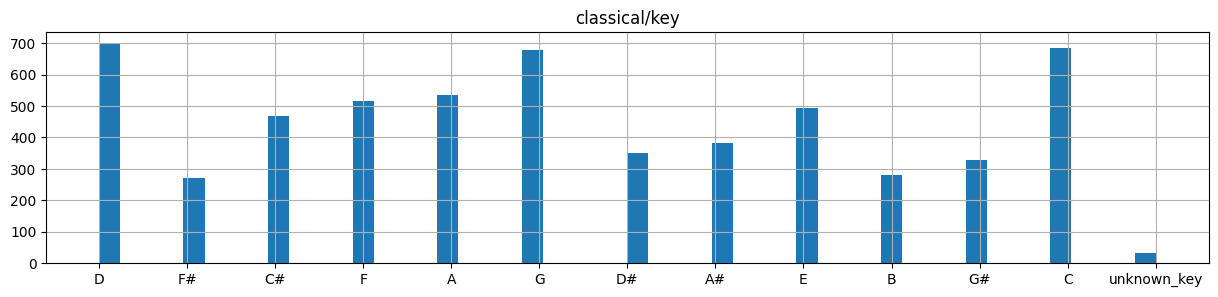

In [1462]:
data_classical['key'].hist(bins=50, figsize=(15,3))
plt.title('classical/key')
plt.show()

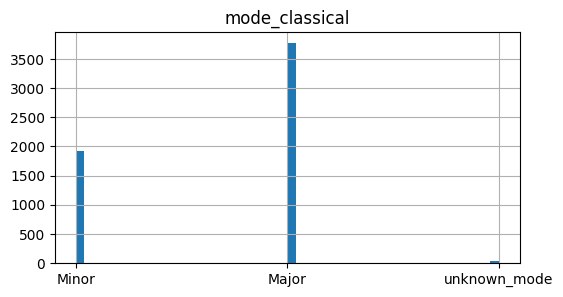

In [1463]:
data_classical['mode'].hist(bins=50, figsize=(6,3))
plt.title('mode_classical')
plt.show()

In [1464]:
data_classical['tempo'].describe()

,tempo
count,5719.000000
mean,95.597013
std,40.699208
min,1.000000
25%,75.129000
50%,92.584000
75%,124.102500
max,212.923000


**Жанр `classical`. Медианный темп - 93.**
**При этом преобладают мажорные тональности. Чаще всего встречаются тональности с тониками - до и ре.**

## Анализ тональностей с точки зрения характеристик

In [1465]:
stat_1 = data.groupby(['key', 'mode']).agg({'valence' : 'median', 'acousticness' : 'median',
                                                  'danceability' : 'median', 'instrumentalness' : 'median',
                                                  'energy' : 'median', 'speechiness': 'median'})
stat_1 = stat_1.sort_values('instrumentalness', ascending=False).head(24)
stat_1

,,valence,acousticness,danceability,instrumentalness,energy,speechiness
key,mode,,,,,,
G,unknown_mode,0.3995,0.1600,0.5350,0.004810,0.6330,0.03950
F#,unknown_mode,0.4535,0.0449,0.4915,0.004045,0.7600,0.05505
A#,unknown_mode,0.3780,0.2685,0.5795,0.003890,0.5945,0.04720
D,Minor,0.4020,0.2300,0.5200,0.003780,0.6000,0.04600
A,Minor,0.4200,0.1830,0.5620,0.002830,0.6090,0.04830
G,Minor,0.3960,0.2020,0.5580,0.001850,0.5885,0.04840
C,Minor,0.3840,0.2845,0.5440,0.001120,0.5485,0.04600
D,unknown_mode,0.4310,0.0492,0.5590,0.001030,0.6290,0.04320
E,Minor,0.3940,0.1360,0.5590,0.000883,0.6600,0.05260


In [1466]:
stat_2 = data.groupby(['mode']).agg({'valence' : 'median', 'acousticness' : 'median',
                                                  'danceability' : 'median', 'instrumentalness' : 'median',
                                                  'energy' : 'median', 'speechiness': 'median'})
stat_2 = stat_2.sort_values('mode', ascending=False).head(24)
stat_2

,valence,acousticness,danceability,instrumentalness,energy,speechiness
mode,,,,,,
unknown_mode,0.474,0.109,0.585,0.000125,0.662,0.0486
Minor,0.440,0.128,0.586,0.000435,0.652,0.0551
Major,0.459,0.143,0.561,0.000093,0.650,0.0462


**Самая "инструментальная" тональность - ре минор. Самая "жизнерадостная" тональность - ля мажор (`valence`). Если сравнивать мажор и минор - здесь очень ярко проступает взаимосвязь с инструментальностью, что мы в будущем будем использовать при заполнении пропусков во второй гипотезе. Медианное значение инструментальности у мажора не очень высокое - по сравнению с минором.**

# 6. Создание новых признаков

**Выделяем новые группы признаков на основе значений других признаков.**

## Обозначение характера музыки

In [1467]:
def f(row):
    if row['energy'] >= 0.83:
        return 'energico'
    elif row['energy'] >= 0.67:
        return 'con_brio'
    elif row['energy'] >= 0.47:
        return 'sostenuto'
    else:
        return 'con_brio'


data['energy_color'] = data.apply(f, axis=1)

In [1468]:
data_test['energy_color'] = data_test.apply(f, axis=1)

In [1469]:
data_train_hypothesis_2['energy_color'] = data_train_hypothesis_2.apply(f, axis=1)

In [1470]:
data_test_hypothesis_2['energy_color'] = data_test_hypothesis_2.apply(f, axis=1)

In [1471]:
data.tail(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,energy_color
63403,0.00597,0.693,189483.0,0.763,0.0,D,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop,con_brio
63404,0.08310,0.782,262773.0,0.472,0.0,G,0.106,-5.016,Minor,0.0441,75.886,0.354,Hip-Hop,sostenuto
63405,0.10200,0.862,267267.0,0.642,0.0,F#,0.272,-13.652,Minor,0.1010,99.201,0.765,Hip-Hop,sostenuto


## Обозначение темпа в музыке

In [1472]:
def t(row):
    if row['tempo'] >= 168:
        return 'presto'
    elif row['tempo'] >= 120:
        return 'allegro'
    elif row['tempo'] >= 108:
        return 'moderato'
    elif row['tempo'] >= 76:
        return 'andante'
    else:
        return 'largo'


data['tempo_color'] = data.apply(t, axis=1)

In [1473]:
data_test['tempo_color'] = data_test.apply(t, axis=1)

In [1474]:
data_train_hypothesis_2['tempo_color'] = data_train_hypothesis_2.apply(t, axis=1)
data_test_hypothesis_2['tempo_color'] = data_test_hypothesis_2.apply(t, axis=1)

In [1475]:
data.head(2)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,energy_color,tempo_color
0,0.480,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,0.450,Country,con_brio,andante
1,0.243,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,0.539,Rock,con_brio,moderato


**Эти медианы понадобятся нам в будущем при заполнении пропусков в третьей гипотезе.**

In [1476]:
data_presto = (data.loc[(data['tempo_color'] == 'presto')])
data_presto['energy'].median()

0.747

In [1477]:
data_allegro = (data.loc[(data['tempo_color'] == 'allegro')])
data_allegro['energy'].median()

0.6940000000000001

In [1478]:
data_moderato = (data.loc[(data['tempo_color'] == 'moderato')])
data_moderato['energy'].median()

0.649

In [1479]:
data_andante = (data.loc[(data['tempo_color'] == 'andante')])
data_andante['energy'].median()

0.609

In [1480]:
data_largo = (data.loc[(data['tempo_color'] == 'largo')])
data_largo['energy'].median()

0.539

## Обозначение динамических оттенков

In [1481]:
data['loudness'].describe()

,loudness
count,63406.000000
mean,-8.956048
std,5.981283
min,-47.046000
25%,-10.647000
50%,-7.201500
75%,-5.130000
max,3.744000


In [1482]:
def loud(row):
    if row['loudness'] >= -5:
        return 'fortissimo'
    elif row['loudness'] >= -15:
        return 'forte'
    elif row['loudness'] >= -25:
        return 'piano'
    elif row['loudness'] >= -40:
        return 'mezzopiano'
    else:
        return 'pianissimo'


data['loud_color'] = data.apply(loud, axis=1)

In [1483]:
data_test['loud_color'] = data_test.apply(loud, axis=1)

In [1484]:
data_train_hypothesis_2['loud_color'] = data_train_hypothesis_2.apply(loud, axis=1)
data_test_hypothesis_2['loud_color'] = data_test_hypothesis_2.apply(loud, axis=1)

In [1485]:
data.tail(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre,energy_color,tempo_color,loud_color
63403,0.00597,0.693,189483.0,0.763,0.0,D,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop,con_brio,allegro,forte
63404,0.08310,0.782,262773.0,0.472,0.0,G,0.106,-5.016,Minor,0.0441,75.886,0.354,Hip-Hop,sostenuto,largo,forte
63405,0.10200,0.862,267267.0,0.642,0.0,F#,0.272,-13.652,Minor,0.1010,99.201,0.765,Hip-Hop,sostenuto,andante,forte


# 7. Корреляция

In [1486]:
data.dtypes

,0
acousticness,float64
danceability,float64
duration_ms,float64
energy,float64
instrumentalness,float64
key,object
liveness,float64
loudness,float64
mode,object
speechiness,float64


In [1487]:
data_types = {'energy': 'interval',
              'acousticness': 'interval',
              'instrumentalness':'interval',
              'danceability':'interval',
              'key':'categorical',
              'liveness': 'interval',
              'loudness':'interval',
              'mode':'categorical',
              'duration_ms':'interval',
              'speechiness':'interval',
              'tempo':'interval',
              'valence':'interval',
              'music_genre':'categorical',
              'tempo_color':'categorical',
              'energy_color':'categorical',
              'loud_color':'categorical'}

In [1488]:
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in data.columns]
interval_cols

['energy',
 'acousticness',
 'instrumentalness',
 'danceability',
 'liveness',
 'loudness',
 'duration_ms',
 'speechiness',
 'tempo',
 'valence']

In [1489]:
phik_overview = data.phik_matrix(interval_cols=interval_cols)

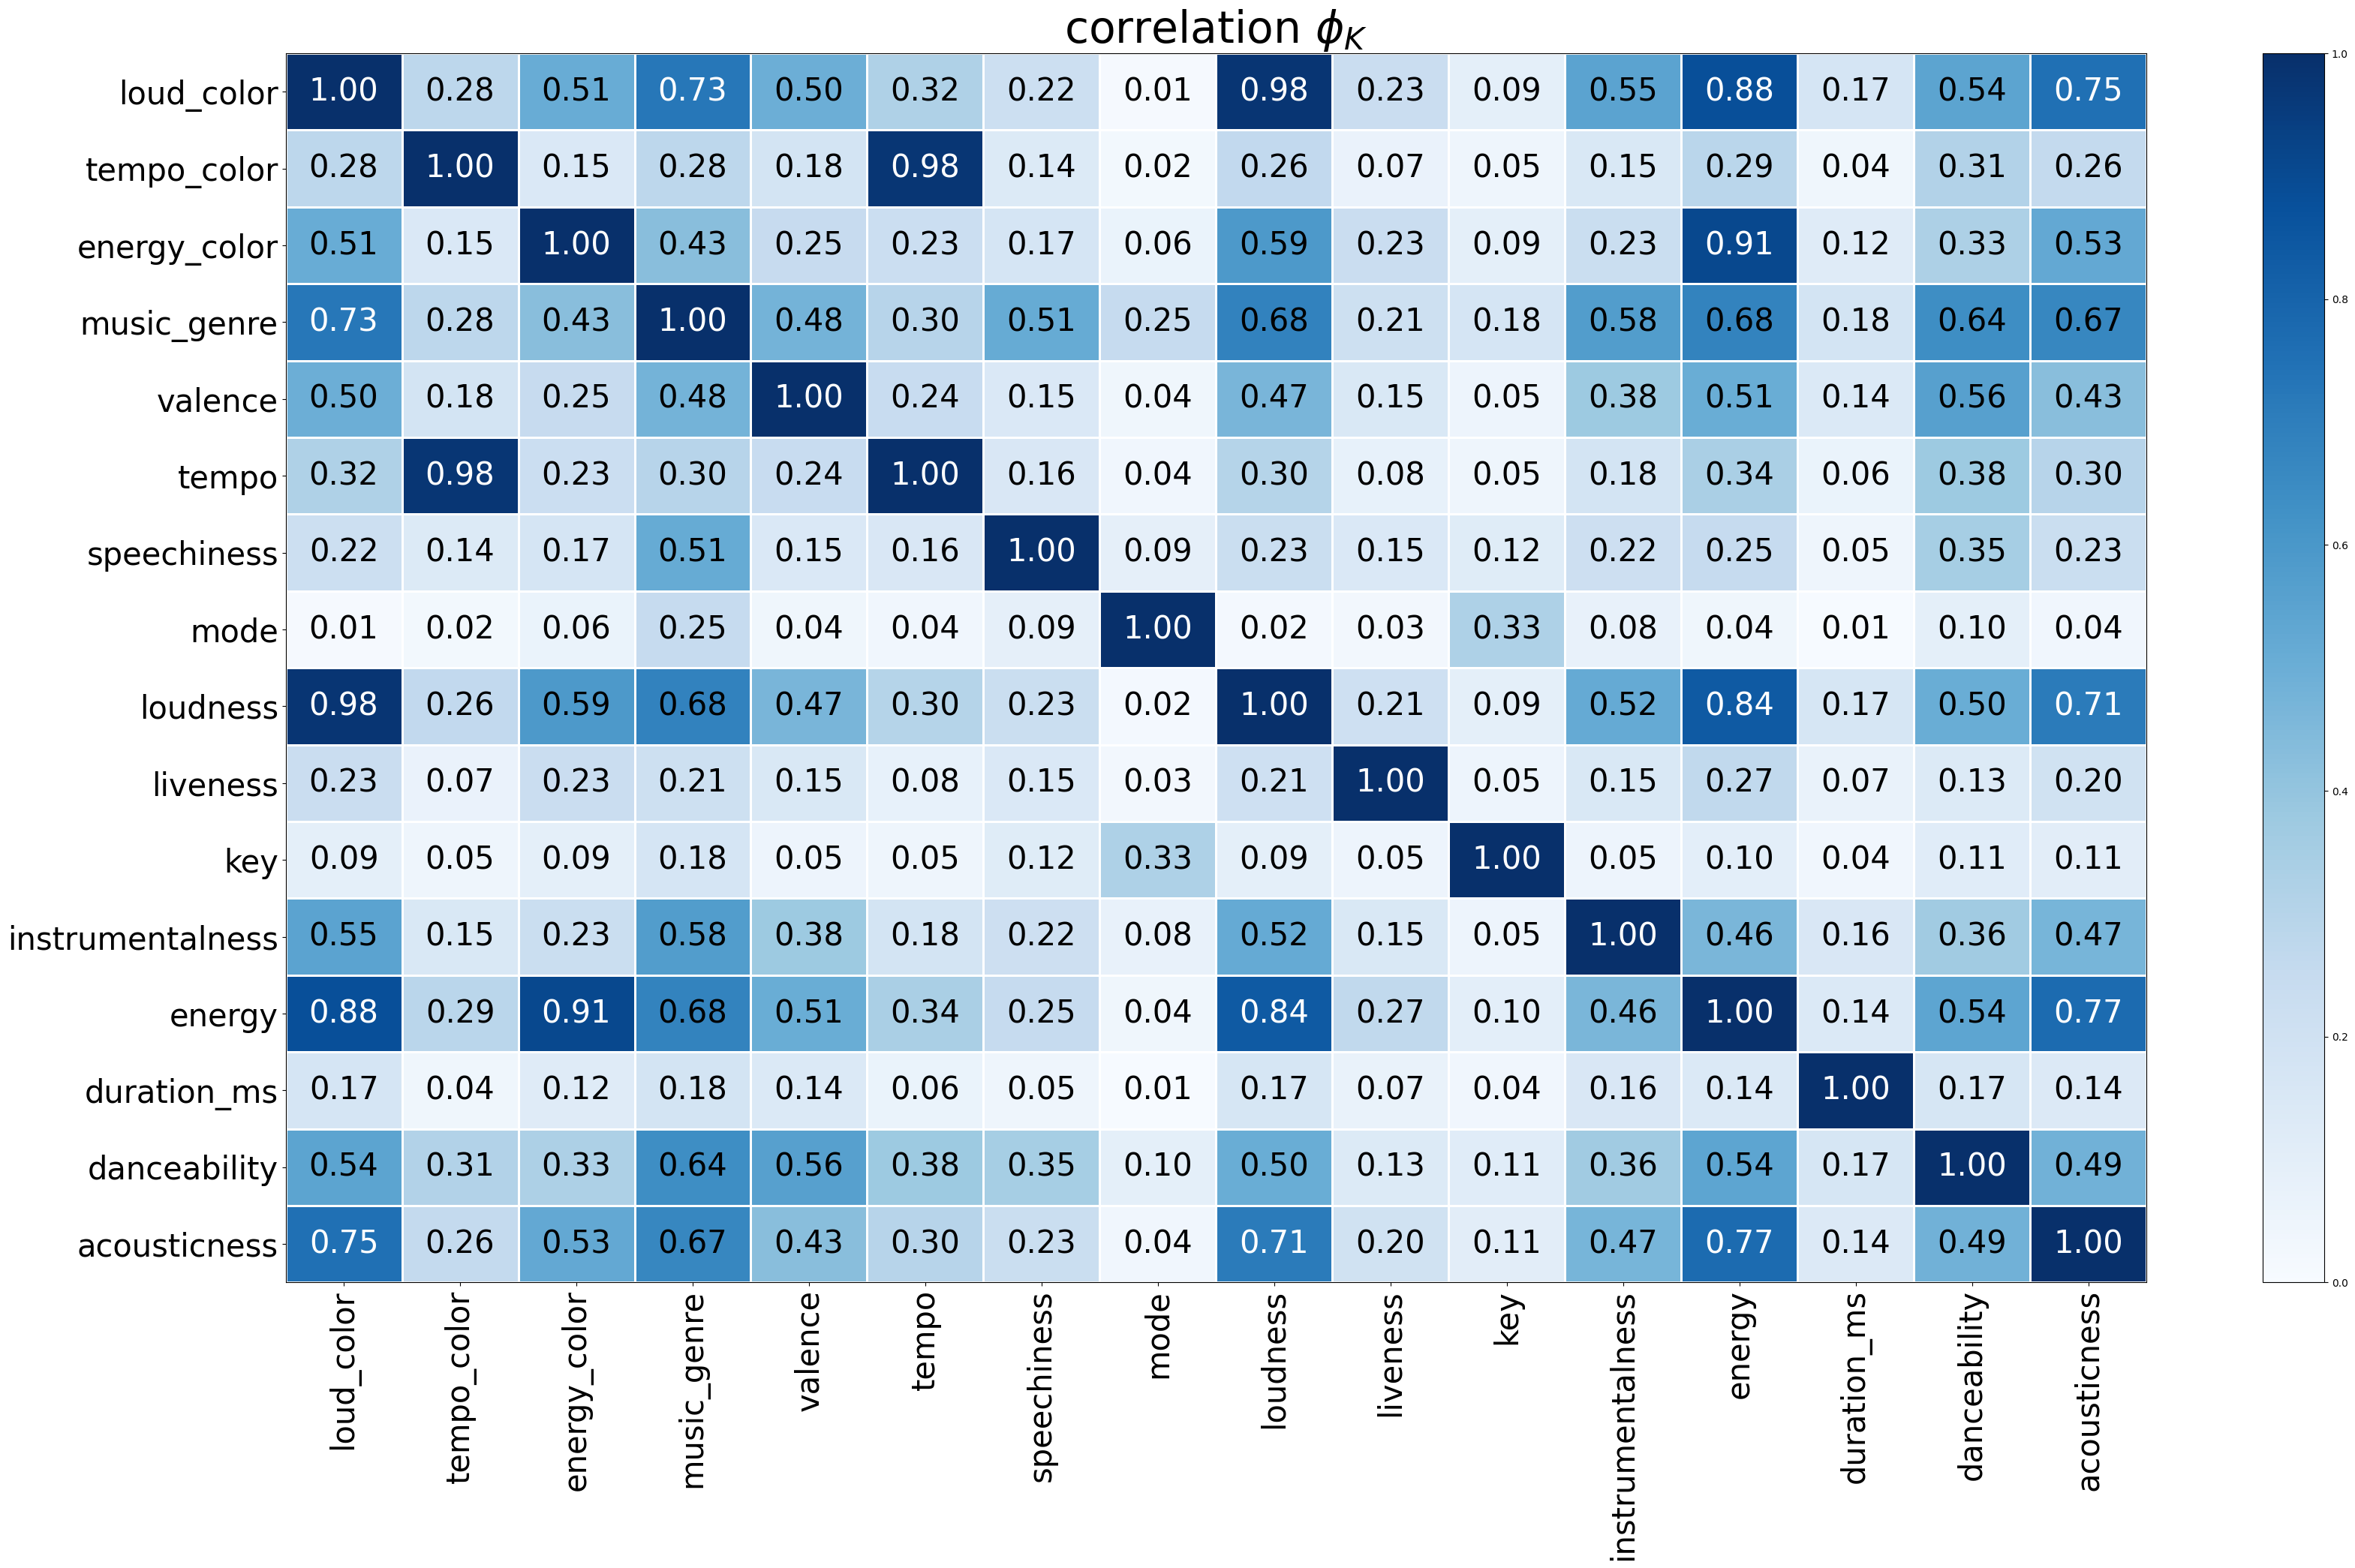

In [1490]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=3,
                        figsize=(35, 21))
plt.tight_layout()

In [1491]:
significance_overview = data.significance_matrix(interval_cols=interval_cols)

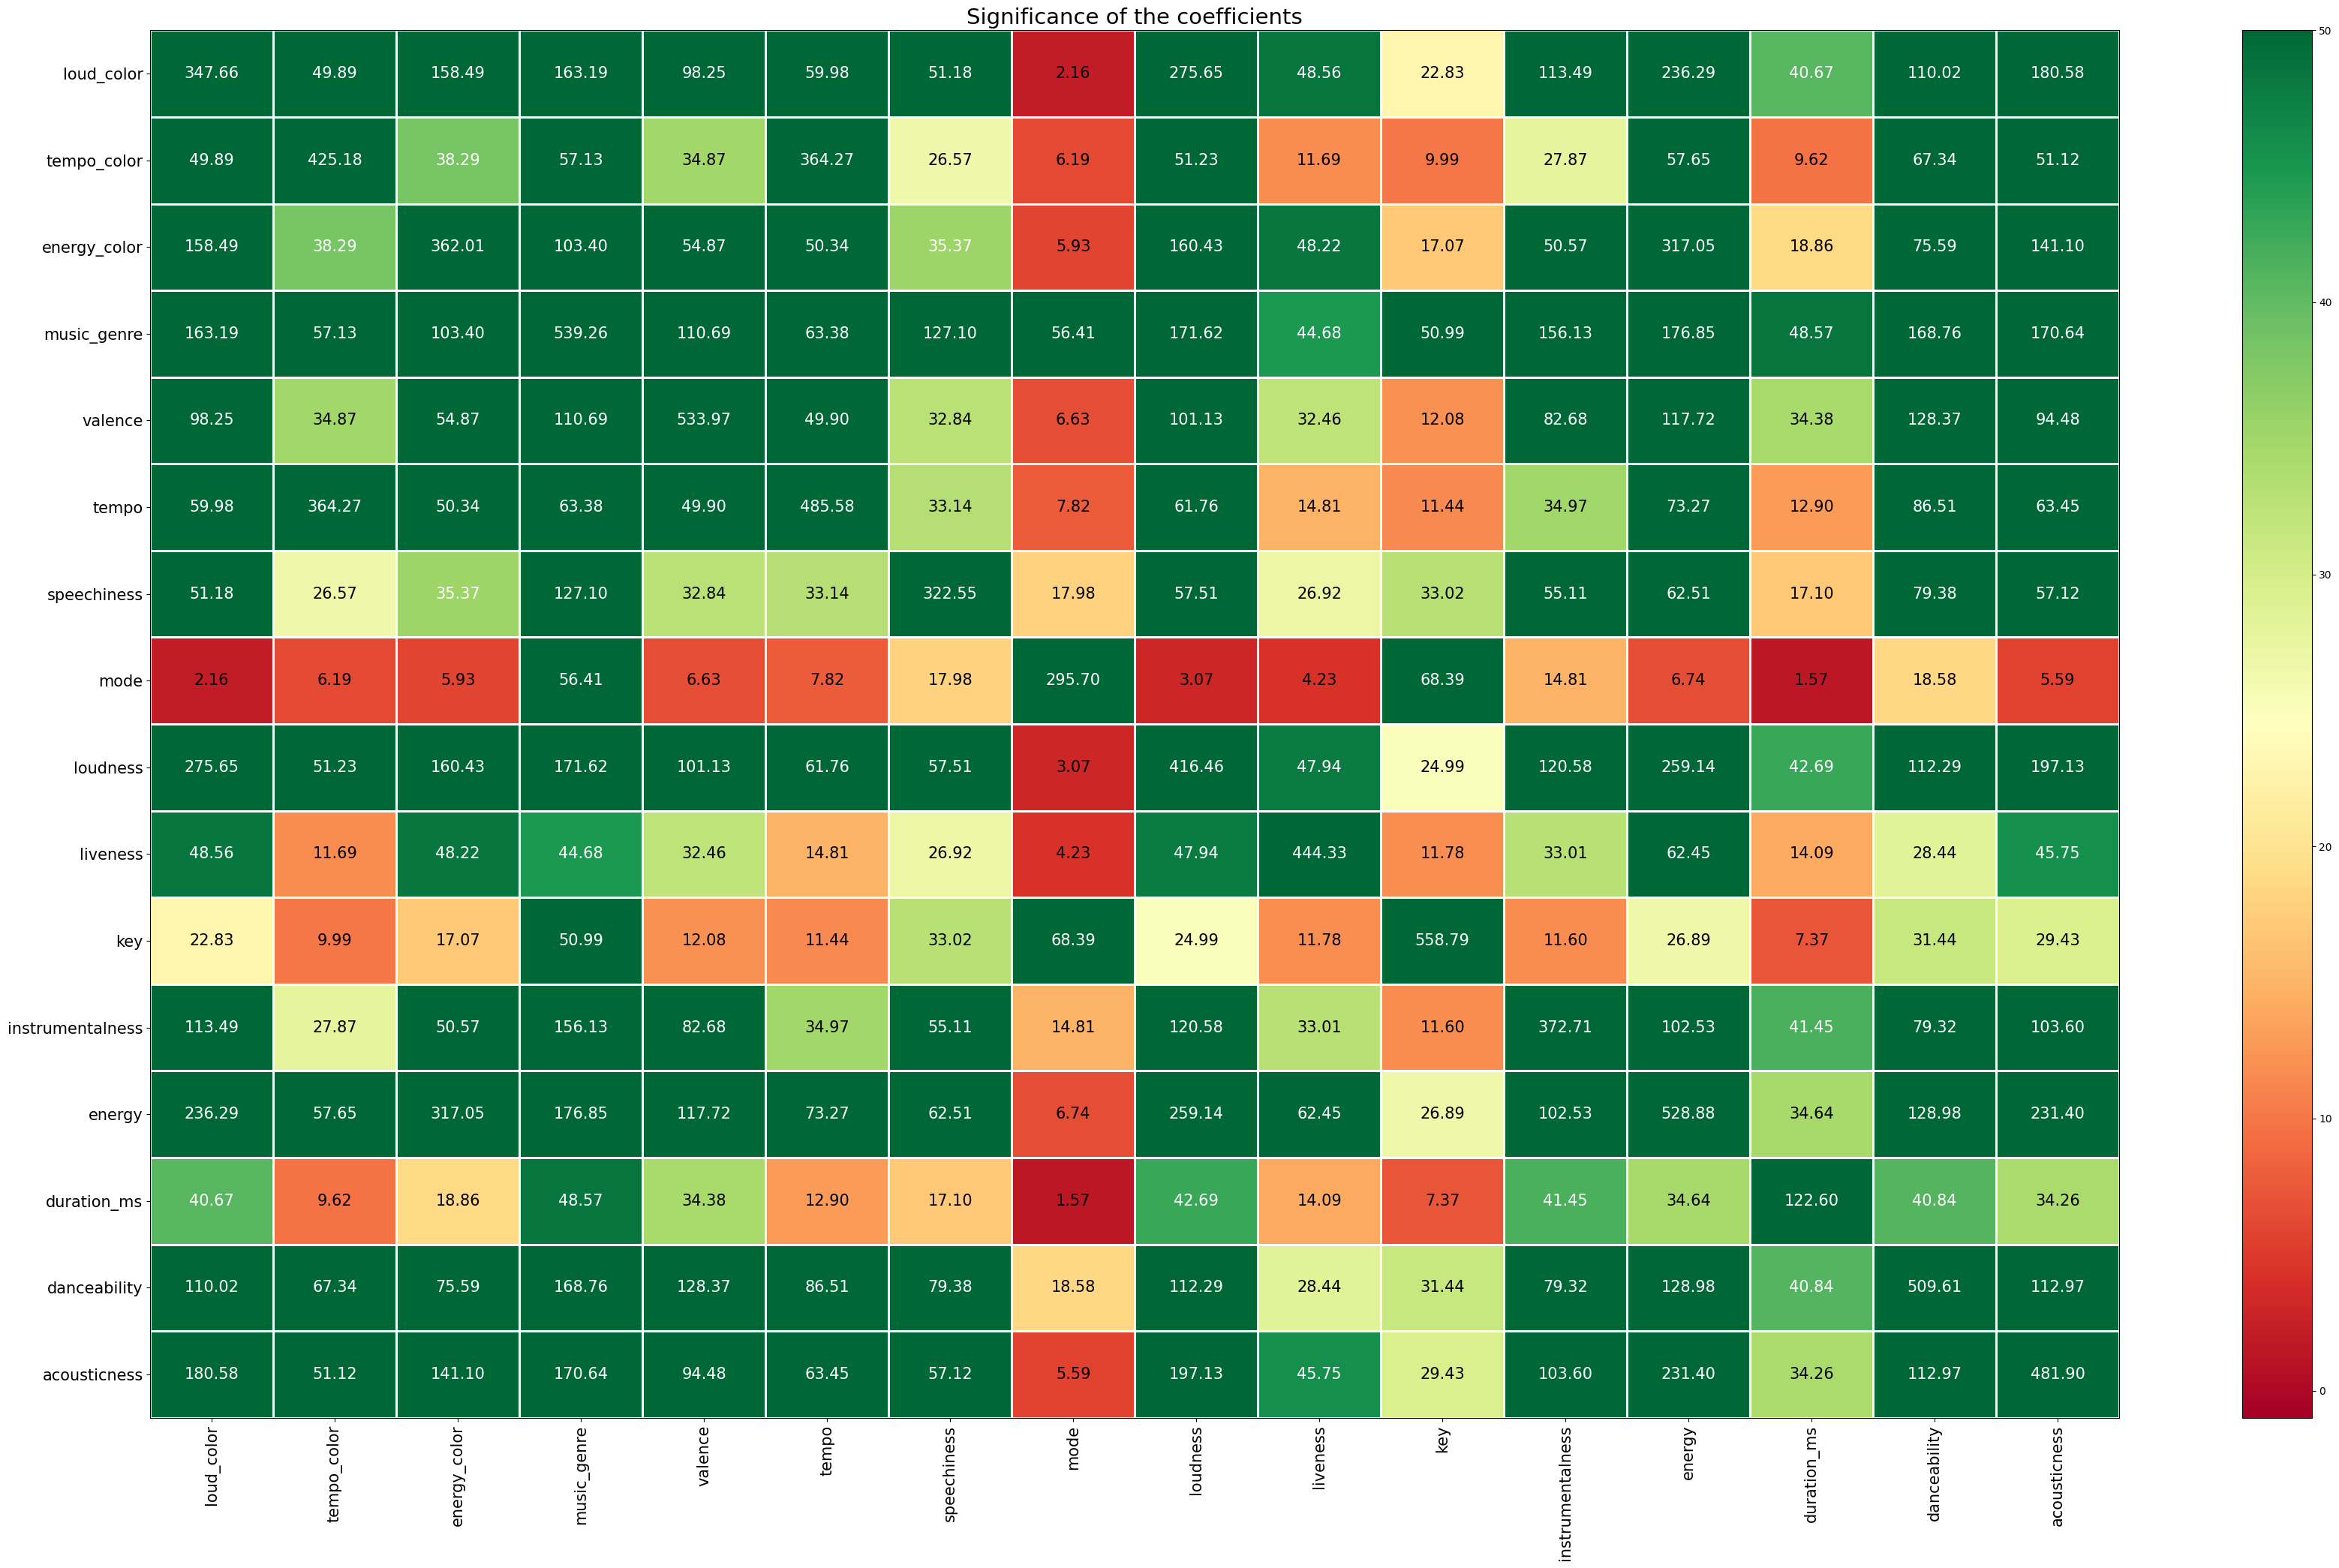

In [1492]:
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-1, vmax=50, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.5, figsize=(35, 21))
plt.tight_layout()

**Высокая корреляция у громкости с энергичностью, у акустичности (`acousticness`) с громкостью. Решено их удалить. Признаки с темпом и энергией мы удаляем, так как на их основе сделали дискретизацию.**

In [1493]:
data = data.drop(columns=['energy', 'loudness', 'acousticness', 'tempo'])
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63406 entries, 0 to 63405
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      63406 non-null  float64
 1   duration_ms       63406 non-null  float64
 2   instrumentalness  63406 non-null  float64
 3   key               63406 non-null  object 
 4   liveness          63406 non-null  float64
 5   mode              63406 non-null  object 
 6   speechiness       63406 non-null  float64
 7   valence           63406 non-null  float64
 8   music_genre       63406 non-null  object 
 9   energy_color      63406 non-null  object 
 10  tempo_color       63406 non-null  object 
 11  loud_color        63406 non-null  object 
dtypes: float64(6), object(6)
memory usage: 5.8+ MB


In [1494]:
data_test = data_test.drop(columns=['energy', 'loudness', 'acousticness', 'tempo'])
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5099 non-null   float64
 1   duration_ms       5099 non-null   float64
 2   instrumentalness  5099 non-null   float64
 3   key               5099 non-null   object 
 4   liveness          5099 non-null   float64
 5   mode              5099 non-null   object 
 6   speechiness       5099 non-null   float64
 7   valence           5099 non-null   float64
 8   energy_color      5099 non-null   object 
 9   tempo_color       5099 non-null   object 
 10  loud_color        5099 non-null   object 
dtypes: float64(6), object(5)
memory usage: 438.3+ KB


In [1495]:
data_train_hypothesis_2 = data_train_hypothesis_2.drop(columns=['energy', 'loudness', 'acousticness', 'tempo'])
data_test_hypothesis_2 = data_test_hypothesis_2.drop(columns=['energy', 'loudness', 'acousticness', 'tempo'])

# Гипотеза №1.

In [1496]:
features = data.drop(['music_genre'], axis=1)
target =  data['music_genre']

In [1497]:
features_train, features_test, target_train, target_test = (train_test_split(features, target,
                                                                               test_size=0.25, random_state=RANDOM_STATE,
                                                                               stratify=target))

In [1498]:
features_train.head(2)

,danceability,duration_ms,instrumentalness,key,liveness,mode,speechiness,valence,energy_color,tempo_color,loud_color
32294,0.442,261787.0,0.000021,A,0.305,Minor,0.0434,0.411,energico,andante,fortissimo
2266,0.909,218707.0,0.926000,C,0.103,Minor,0.1560,0.572,sostenuto,andante,forte


In [1499]:
features_train.dtypes

,0
danceability,float64
duration_ms,float64
instrumentalness,float64
key,object
liveness,float64
mode,object
speechiness,float64
valence,float64
energy_color,object
tempo_color,object


In [1500]:
ohe_features = ['mode', 'energy_color',  'loud_color', 'tempo_color', 'key']

numeric = (['duration_ms', 'instrumentalness',
            'speechiness',  'valence', 'danceability', 'liveness'])

In [1501]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore', drop='first'),
        ohe_features
),
    (
        StandardScaler(),
        numeric
    ),

    remainder = 'passthrough', force_int_remainder_cols=False
)

### 1. **LogisticRegression.**

In [1502]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE,  C=1.0, solver='newton-cg')

In [1503]:
lr_pipeline = Pipeline(steps = [('ohe', col_transformer),

                                   ('model', lr_model)],
                                    verbose = True
                           )

In [1504]:
lr_pipeline.fit(features_train, target_train)

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.7s


Pipeline(steps=[('ohe',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                                   'instrumentalness',
                                                   'speechiness', 'valence',
                                                   'danceability',
                                                   'liveness'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=12345, solver='newton-cg'))],
         verbose=True)

In [1505]:
fbeta_lr_1 = fbeta_score(target_test,lr_pipeline.predict(features_test),average='macro',beta=0.5)
fbeta_lr_1

0.37352487347349644

### 2. **RandomForestClassifier.**

In [1506]:
col_transformer2 = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99997),
        ohe_features
),
    remainder='passthrough', force_int_remainder_cols=False
)

In [1507]:
rf_model = RandomForestClassifier(n_estimators=105,max_depth=38,min_samples_leaf = 3, min_samples_split = 2,
                                  random_state=RANDOM_STATE, class_weight='balanced')

rf_pipeline = Pipeline(steps = [('ohe', col_transformer2),

                                   ('model', rf_model)],
                                    verbose = True
                           )

rf_pipeline.fit(features_train, target_train)

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  14.5s


Pipeline(steps=[('ohe',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99997),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=38,
                                        min_samples_leaf=3, n_estimators=105,
                                        random_state=12345))],
         verbose=True)

In [1508]:
rf_pred = rf_pipeline.predict(features_test)

In [1509]:
fbeta_rf_1 = fbeta_score(target_test,rf_pred,average='macro',beta=0.5)
fbeta_rf_1

0.5946521139195157

Эта модель на Kaggle показала такие результаты `fbeta_score`: `0.68039 - private score` и
`0.68026 - public score`. Это второй лучший результат в данном проекте.

# Гипотеза №2.

In [1510]:
features2 = data_train_hypothesis_2.drop(['music_genre'], axis=1)
target2 =  data_train_hypothesis_2['music_genre']

In [1511]:
features_train2, features_test2, target_train2, target_test2 = (train_test_split(features2, target2,
                                                                               test_size=0.25, random_state=RANDOM_STATE,
                                                                               stratify=target2))

### 3. **LogisticRegression.**

In [1512]:
lr2 = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE,  C=1.0, solver='newton-cg')

In [1513]:
lr_pipeline2 = Pipeline(steps = [('ohe', col_transformer),

                                   ('model', lr2)],
                                    verbose = True
                           )

In [1514]:
lr_pipeline2.fit(features_train2, target_train2)

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   4.1s


Pipeline(steps=[('ohe',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                                   'instrumentalness',
                                                   'speechiness', 'valence',
                                                   'danceability',
                                                   'liveness'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=12345, solver='newton-cg'))],
         verbose=True)

In [1515]:
fbeta_lr_2 = fbeta_score(target_test2,lr_pipeline2.predict(features_test2),average='macro',beta=0.5)
fbeta_lr_2

0.3690467818981473

### 4. **RandomForestClassifier**

In [1516]:
rf_model2 = RandomForestClassifier(n_estimators=105,max_depth=38,min_samples_leaf = 3, min_samples_split = 2,
                                  random_state=RANDOM_STATE, class_weight='balanced')

rf_pipeline2 = Pipeline(steps = [('ohe', col_transformer2),

                                   ('model', rf_model2)],
                                    verbose = True
                           )

rf_pipeline2.fit(features_train2, target_train2)

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  15.5s


Pipeline(steps=[('ohe',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99997),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=38,
                                        min_samples_leaf=3, n_estimators=105,
                                        random_state=12345))],
         verbose=True)

In [1517]:
fbeta_rf_2 = fbeta_score(target_test2,rf_pipeline2.predict(features_test2),average='macro',beta=0.5)
fbeta_rf_2

0.578152220653849

# **Гипотеза №3. Заполнение пропусков в обучающем и тестовом наборе значениями, на основе значений, полученных в процессе анализа обучающей выборки.**

**Наша гипотеза состоит в том, что мы заполняем пропуски в обучающей и в тестовой выборке на основе значений, полученных в процессе анализа данных в самом начале исследования.**

### Пропущенные значения

In [1518]:
data_train_hypothesis_3.isna().sum()

,0
acousticness,1
danceability,1
duration_ms,1
energy,1
instrumentalness,1
key,735
liveness,1
loudness,1
mode,507
speechiness,1


In [1519]:
presto = data_train_hypothesis_3['energy'] >= 0.747
data_train_hypothesis_3.loc[presto, 'tempo'] = data_train_hypothesis_3.loc[presto, 'tempo'].fillna(176)

In [1520]:
allegro = data_train_hypothesis_3['energy'] >= 0.694
data_train_hypothesis_3.loc[allegro, 'tempo'] = data_train_hypothesis_3.loc[allegro, 'tempo'].fillna(138)

In [1521]:
moderato = data_train_hypothesis_3['energy'] >= 0.649
data_train_hypothesis_3.loc[moderato, 'tempo'] = data_train_hypothesis_3.loc[moderato, 'tempo'].fillna(114)

In [1522]:
andante = data_train_hypothesis_3['energy'] >= 0.609
data_train_hypothesis_3.loc[andante, 'tempo'] = data_train_hypothesis_3.loc[andante, 'tempo'].fillna(93)

In [1523]:
largo = data_train_hypothesis_3['energy'] <= 0.601
data_train_hypothesis_3.loc[largo, 'tempo'] = data_train_hypothesis_3.loc[largo, 'tempo'].fillna(71)

In [1524]:
data_train_hypothesis_3.isna().sum()

,0
acousticness,1
danceability,1
duration_ms,1
energy,1
instrumentalness,1
key,735
liveness,1
loudness,1
mode,507
speechiness,1


In [1525]:
minor = data_train_hypothesis_3['instrumentalness'] >= 0.0003
data_train_hypothesis_3.loc[minor, 'mode'] = data_train_hypothesis_3.loc[minor, 'mode'].fillna('Minor')

major = data_train_hypothesis_3['instrumentalness'] < 0.0003
data_train_hypothesis_3.loc[major, 'mode'] = data_train_hypothesis_3.loc[major, 'mode'].fillna('Major')

In [1526]:
data_train_hypothesis_3.isna().sum()

,0
acousticness,1
danceability,1
duration_ms,1
energy,1
instrumentalness,1
key,735
liveness,1
loudness,1
mode,1
speechiness,1


In [1527]:
minor_a = (data_train_hypothesis_3['instrumentalness'] >= 0.00256) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_a, 'key'] = data_train_hypothesis_3.loc[minor_a, 'key'].fillna('A')

In [1528]:
minor_g = (data_train_hypothesis_3['instrumentalness'] >= 0.001925) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_g, 'key'] = data_train_hypothesis_3.loc[minor_g, 'key'].fillna('G')

In [1529]:
minor_c = (data_train_hypothesis_3['instrumentalness'] >= 0.00114) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_c, 'key'] = data_train_hypothesis_3.loc[minor_c, 'key'].fillna('C')

In [1530]:
minor_d = (data_train_hypothesis_3['instrumentalness'] >= 0.000976) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_d, 'key'] = data_train_hypothesis_3.loc[minor_d, 'key'].fillna('D')

In [1531]:
minor_f = (data_train_hypothesis_3['instrumentalness'] >= 0.00055) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_f, 'key'] = data_train_hypothesis_3.loc[minor_f, 'key'].fillna('F')

In [1532]:
minor_a_d = (data_train_hypothesis_3['instrumentalness'] >= 0.000106) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_a_d, 'key'] = data_train_hypothesis_3.loc[minor_a_d, 'key'].fillna('A#')

In [1533]:
minor_f_d = (data_train_hypothesis_3['instrumentalness'] >= 0.00004) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_f_d, 'key'] = data_train_hypothesis_3.loc[minor_f_d, 'key'].fillna('F#')

In [1534]:
minor_c_d = (data_train_hypothesis_3['instrumentalness'] <= 0.000039) & (data_train_hypothesis_3['mode'] >= 'Minor')
data_train_hypothesis_3.loc[minor_c_d, 'key'] = data_train_hypothesis_3.loc[minor_c_d, 'key'].fillna('C#')

In [1535]:
major_c = (data_train_hypothesis_3['instrumentalness'] >= 0.000249) & (data_train_hypothesis_3['mode'] >= 'Major')
data_train_hypothesis_3.loc[major_c, 'key'] = data_train_hypothesis_3.loc[major_c, 'key'].fillna('C')

In [1536]:
major_e = (data_train_hypothesis_3['instrumentalness'] >= 0.000093) & (data_train_hypothesis_3['mode'] >= 'Major')
data_train_hypothesis_3.loc[major_e, 'key'] = data_train_hypothesis_3.loc[major_e, 'key'].fillna('E')

In [1537]:
major_a = (data_train_hypothesis_3['instrumentalness'] <= 0.000092) & (data_train_hypothesis_3['mode'] >= 'Major')
data_train_hypothesis_3.loc[major_a, 'key'] = data_train_hypothesis_3.loc[major_a, 'key'].fillna('A')

In [1538]:
data_train_hypothesis_3.isna().sum()

,0
acousticness,1
danceability,1
duration_ms,1
energy,1
instrumentalness,1
key,1
liveness,1
loudness,1
mode,1
speechiness,1


In [1539]:
data_train_hypothesis_3 = (data_train_hypothesis_3.dropna(subset=['energy', 'duration_ms', 'danceability', 'acousticness', 'instrumentalness',
                                                                 'liveness', 'loudness', 'speechiness','valence',
                                                                 'key', 'mode', 'tempo']).reset_index(drop=True)
)

In [1540]:
data_train_hypothesis_3.isna().sum()

,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0
loudness,0
mode,0
speechiness,0


### Создание новых признаков

In [1541]:
data_train_hypothesis_3.dtypes

,0
acousticness,float64
danceability,float64
duration_ms,float64
energy,float64
instrumentalness,float64
key,object
liveness,float64
loudness,float64
mode,object
speechiness,float64


In [1542]:
data_train_hypothesis_3['energy_color'] = data_train_hypothesis_3.apply(f, axis=1)
data_train_hypothesis_3['tempo_color'] = data_train_hypothesis_3.apply(t, axis=1)
data_train_hypothesis_3['loud_color'] = data_train_hypothesis_3.apply(loud, axis=1)

### Пропущенные значения

In [1543]:
data_test_hypothesis_3.isna().sum()

,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,158
liveness,0
loudness,0
mode,149
speechiness,0


In [1544]:
minor_2 = data_test_hypothesis_3['instrumentalness'] >= 0.0003
data_test_hypothesis_3.loc[minor_2, 'mode'] = data_test_hypothesis_3.loc[minor_2, 'mode'].fillna('Minor')

major_2 = data_test_hypothesis_3['instrumentalness'] < 0.0003
data_test_hypothesis_3.loc[major_2, 'mode'] = data_test_hypothesis_3.loc[major_2, 'mode'].fillna('Major')

In [1545]:
presto_2 = data_test_hypothesis_3['energy'] >= 0.747
data_test_hypothesis_3.loc[presto_2, 'tempo'] = data_test_hypothesis_3.loc[presto_2, 'tempo'].fillna(176)

In [1546]:
allegro_2 = data_test_hypothesis_3['energy'] >= 0.694
data_test_hypothesis_3.loc[allegro_2, 'tempo'] = data_test_hypothesis_3.loc[allegro_2, 'tempo'].fillna(138)

In [1547]:
moderato_2 = data_test_hypothesis_3['energy'] >= 0.649
data_test_hypothesis_3.loc[moderato_2, 'tempo'] = data_test_hypothesis_3.loc[moderato_2, 'tempo'].fillna(114)

In [1548]:
largo_2 = data_test_hypothesis_3['energy'] <= 0.539
data_test_hypothesis_3.loc[largo_2, 'tempo'] = data_test_hypothesis_3.loc[largo_2, 'tempo'].fillna(71)

In [1549]:
data_test_hypothesis_3.isna().sum()

,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,158
liveness,0
loudness,0
mode,0
speechiness,0


In [1550]:
minor_a_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.00256) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_a_2, 'key'] = data_test_hypothesis_3.loc[minor_a_2, 'key'].fillna('A')

In [1551]:
minor_g_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.001925) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_g_2, 'key'] = data_test_hypothesis_3.loc[minor_g_2, 'key'].fillna('G')

In [1552]:
minor_c_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.00114) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_c_2, 'key'] = data_test_hypothesis_3.loc[minor_c_2, 'key'].fillna('C')

In [1553]:
minor_d_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.00976) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_d_2, 'key'] = data_test_hypothesis_3.loc[minor_d_2, 'key'].fillna('D')

In [1554]:
minor_f_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.00055) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_f_2, 'key'] = data_test_hypothesis_3.loc[minor_f_2, 'key'].fillna('F')

In [1555]:
minor_a_d_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.000106) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_a_d_2, 'key'] = data_test_hypothesis_3.loc[minor_a_d_2, 'key'].fillna('A#')

In [1556]:
minor_f_d_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.00004) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_f_d_2, 'key'] = data_test_hypothesis_3.loc[minor_f_d_2, 'key'].fillna('F#')

In [1557]:
minor_c_d_2 = (data_test_hypothesis_3['instrumentalness'] <= 0.000039) & (data_test_hypothesis_3['mode'] >= 'Minor')
data_test_hypothesis_3.loc[minor_c_d_2, 'key'] = data_test_hypothesis_3.loc[minor_c_d_2, 'key'].fillna('C#')

In [1558]:
major_c_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.000249) & (data_test_hypothesis_3['mode'] >= 'Major')
data_test_hypothesis_3.loc[major_c_2, 'key'] = data_test_hypothesis_3.loc[major_c_2, 'key'].fillna('C')

In [1559]:
major_e_2 = (data_test_hypothesis_3['instrumentalness'] >= 0.000093) & (data_test_hypothesis_3['mode'] >= 'Major')
data_test_hypothesis_3.loc[major_e_2, 'key'] = data_test_hypothesis_3.loc[major_e_2, 'key'].fillna('E')

In [1560]:
major_a_2 = (data_test_hypothesis_3['instrumentalness'] <= 0.000092) & (data_test_hypothesis_3['mode'] >= 'Major')
data_test_hypothesis_3.loc[major_a_2, 'key'] = data_test_hypothesis_3.loc[major_a_2, 'key'].fillna('A')

In [1561]:
data_test_hypothesis_3.isna().sum()

,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0
loudness,0
mode,0
speechiness,0


In [1562]:
data_test_hypothesis_3['tempo'] = data_test_hypothesis_3['tempo'].fillna(3)

### Создание новых признаков

In [1563]:
data_test_hypothesis_3['energy_color'] = data_test_hypothesis_3.apply(f, axis=1)
data_test_hypothesis_3['tempo_color'] = data_test_hypothesis_3.apply(t, axis=1)
data_test_hypothesis_3['loud_color'] = data_test_hypothesis_3.apply(loud, axis=1)

In [1564]:
data_train_hypothesis_3 = data_train_hypothesis_3.drop(columns=['energy', 'loudness', 'acousticness', 'tempo'])
data_test_hypothesis_3 = data_test_hypothesis_3.drop(columns=['energy', 'loudness', 'acousticness', 'tempo'])

In [1565]:
data_test_hypothesis_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5099 non-null   float64
 1   duration_ms       5099 non-null   float64
 2   instrumentalness  5099 non-null   float64
 3   key               5099 non-null   object 
 4   liveness          5099 non-null   float64
 5   mode              5099 non-null   object 
 6   speechiness       5099 non-null   float64
 7   valence           5099 non-null   float64
 8   energy_color      5099 non-null   object 
 9   tempo_color       5099 non-null   object 
 10  loud_color        5099 non-null   object 
dtypes: float64(6), object(5)
memory usage: 438.3+ KB


In [1566]:
features3 = data_train_hypothesis_3.drop(['music_genre'], axis=1)
target3=  data_train_hypothesis_3['music_genre']

In [1567]:
features_train3, features_test3, target_train3, target_test3 = (train_test_split(features3, target3,
                                                                               test_size=0.25, random_state=RANDOM_STATE,
                                                                               stratify=target3))

### 5. **LogisticRegression.**

In [1568]:
model_lr_3 = LogisticRegression(max_iter=1000, class_weight='balanced',
                                      random_state=RANDOM_STATE,  C=1.0, solver='newton-cg')

In [1569]:
lr_pipeline3 = Pipeline(steps = [('ohe', col_transformer),

                                   ('model', model_lr_3)],
                                    verbose = True
                           )

In [1570]:
lr_pipeline3.fit(features_train3, target_train3)

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   7.1s


Pipeline(steps=[('ohe',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_ms',
                                                   'instrumentalness',
                                                   'speechiness', 'valence',
                                                   'danceability',
                                                   'liveness'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=12345, solver='newton-cg'))],
         verbose=True)

In [1571]:
fbeta_lr_3 = fbeta_score(target_train3, lr_pipeline3.predict(features_train3), average="macro", beta=0.5)
fbeta_lr_3


0.37608696038309797

### 6. **RandomForestClassifier.**

In [1572]:
rf_model3 = RandomForestClassifier(n_estimators=105,max_depth=38,min_samples_leaf = 3, min_samples_split = 2,
                                  random_state=RANDOM_STATE, class_weight='balanced')

rf_pipeline3 = Pipeline(steps = [('ohe', col_transformer2),

                                   ('model', rf_model3)],
                                    verbose = True
                           )

rf_pipeline3.fit(features_train3, target_train3)

[Pipeline] ............... (step 1 of 2) Processing ohe, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  16.8s


Pipeline(steps=[('ohe',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99997),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=38,
                                        min_samples_leaf=3, n_estimators=105,
                                        random_state=12345))],
         verbose=True)

In [1573]:
fbeta_rf_3 = fbeta_score(target_test3, rf_pipeline3.predict(features_test3), average='macro', beta=0.5)
fbeta_rf_3

0.5853692559297674

In [1574]:
model2 = [('RandomForestClassifier', fbeta_rf_1, fbeta_rf_2, fbeta_rf_3),
         ('LogisticRegression', fbeta_lr_1, fbeta_lr_2, fbeta_lr_3)]

table = pd.DataFrame(model2)
table.columns = ['model', '1 hypothesis', '2 hypothesis', '3 hypothesis']

In [1575]:
table

,model,1 hypothesis,2 hypothesis,3 hypothesis
0,RandomForestClassifier,0.594652,0.578152,0.585369
1,LogisticRegression,0.373525,0.369047,0.376087


**Будем тестировать данные из третьей гипотезы. Попробуем разные методы балансировки данных, воспользуемся `permutation_importance` для отбора самых важных признаков.**

## SMOTE/RandomUnderSampler

#### 7. **LogisticRegression / SMOTE.**

In [1576]:
categorical_columns = features_train3.select_dtypes(include='object').columns.to_list()
numeric_columns = features_train3.select_dtypes(exclude='object').columns.to_list()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

scaler = StandardScaler()
col_transformer_ohe = ColumnTransformer(
        transformers=[
            ('category', encoder_ohe, categorical_columns),
            ('scaler', scaler, numeric_columns)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

sampler_upsample = SMOTE(random_state=12345)
model_logreg = LogisticRegression(random_state=12345, max_iter=1000, C=1.0, solver='newton-cg')

pipeline_logreg = Pipeline(steps=[
        ('preprocessor', col_transformer_ohe),
        ('sampling', sampler_upsample),
        ('model', model_logreg)
    ])

In [1577]:
p = pipeline_logreg.fit(features_train3, target_train3)

In [1578]:
fbeta_lr_smote = fbeta_score(target_test3,p.predict(features_test3), average='macro', beta=0.5)
fbeta_lr_smote

0.3714300753979584

#### 8. **LogisticRegression / RandomUnderSampler.**

In [1579]:
sampler_rusample = RandomUnderSampler(random_state=RANDOM_STATE)

In [1580]:
model_logreg2 = LogisticRegression(random_state=12345, max_iter=1000, C=1.0, solver='newton-cg')

pipeline_logreg = Pipeline(steps=[
        ('preprocessor', col_transformer_ohe),
        ('sampling', sampler_rusample),
        ('model', model_logreg2)
    ])

In [1581]:
p2 = pipeline_logreg.fit(features_train3, target_train3)

In [1582]:
fbeta_lr_rus = fbeta_score(target_test3, p2.predict(features_test3), average='macro', beta=0.5)
fbeta_lr_rus

0.369230943452983

#### 9. **RandomForestClassifier / SMOTE.**

In [1583]:
rf_model_up = RandomForestClassifier(n_estimators=105,max_depth=38,min_samples_leaf = 3, min_samples_split = 2, random_state=RANDOM_STATE)

In [1584]:
pipeline_rf_up = Pipeline(steps=[
        ('preprocessor', col_transformer2),
        ('sampling', sampler_upsample),
        ('model', rf_model_up)
    ])

In [1585]:
pipeline_rf_up.fit(features_train3, target_train3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99997),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key'])])),
                ('sampling', SMOTE(random_state=12345)),
                ('model',
                 RandomForestClassifier(max_depth=38, min_samples_leaf=3,
                                        n_estimators=105,
                                        random_state=12345))])

In [1586]:
fbeta_rf_up = fbeta_score(target_test3, pipeline_rf_up.predict(features_test3), average='macro', beta=0.5)
fbeta_rf_up

0.5883103934746764

Эта модель на Kaggle показала такие результаты `fbeta_score`: `0.74 - private score` и
`0.73 - public score`. Она является лучшей в этом проекте.

#### 10. **RandomForestClassifier/RandomUnderSampler.**

In [1587]:
rf_model_rus = RandomForestClassifier(n_estimators=105,max_depth=38,min_samples_leaf = 3,
                                      min_samples_split = 2, random_state=RANDOM_STATE)

In [1588]:
pipeline_rf_rus = Pipeline(steps=[
        ('preprocessor', col_transformer2),
        ('sampling', sampler_rusample),
        ('model', rf_model_rus)
    ])

In [1589]:
pipeline_rf_rus.fit(features_train3, target_train3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99997),
                                                  ['mode', 'energy_color',
                                                   'loud_color', 'tempo_color',
                                                   'key'])])),
                ('sampling', RandomUnderSampler(random_state=12345)),
                ('model',
                 RandomForestClassifier(max_depth=38, min_samples_leaf=3,
                                        n_estimators=105,
                                        random_state=12345))])

In [1590]:
fbeta_rf_rus = fbeta_score(target_test3, pipeline_rf_rus.predict(features_test3), average='macro', beta=0.5)
fbeta_rf_rus

0.5646122269289805

## FeatureImportance

In [1591]:
feature_names = features_train.columns.tolist()

In [1592]:
start_time = time.time()
result = permutation_importance(
   pipeline_rf_rus, features_train, target_train, n_repeats=10, random_state=RANDOM_STATE, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 146.530 seconds


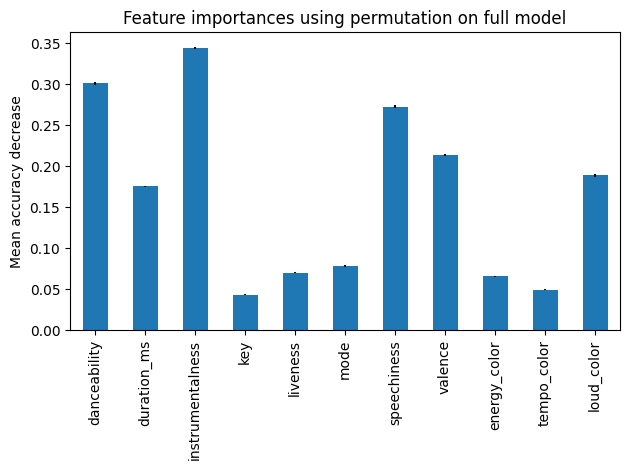

In [1593]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

**На графике видно, что `key`, `tempo_color`, `liveness` не являются самыми важными признаками для данной модели (RandomForestClassifier). Самым важным признаком является инструментальность. Решено убрать признак с тоникой (`key`).**

#### 11. **RandomForestClassifier / SMOTE**

In [1594]:
test = data_test_hypothesis_3.copy()

In [1595]:
features_train3 = features_train3.drop(columns=['key'], axis=1)
features_test3 = features_test3.drop(columns=['key'], axis=1)
data_test_hypothesis_3 = data_test_hypothesis_3.drop(columns=['key'], axis=1)

In [1596]:
ohe_features3 = ['loud_color', 'mode', 'energy_color', 'tempo_color']

numeric3 = (['duration_ms', 'instrumentalness', 'liveness',
            'speechiness',  'valence', 'danceability'])

col_transformer3 = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99997),
        ohe_features3
),
    remainder='passthrough', force_int_remainder_cols=False
)

In [1597]:
rf_model_up2 = RandomForestClassifier(n_estimators=105,max_depth=38,min_samples_leaf = 3, min_samples_split = 2, random_state=RANDOM_STATE)

In [1598]:
pipeline_rf_up2 = Pipeline(steps=[
        ('preprocessor', col_transformer3),
        ('sampling', sampler_upsample),
        ('model', rf_model_up2)
    ])

In [1599]:
pipeline_rf_up2.fit(features_train3, target_train3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99997),
                                                  ['loud_color', 'mode',
                                                   'energy_color',
                                                   'tempo_color'])])),
                ('sampling', SMOTE(random_state=12345)),
                ('model',
                 RandomForestClassifier(max_depth=38, min_samples_leaf=3,
                                        n_estimators=105,
                                        random_state=12345))])

In [1600]:
fbeta_rf_up_2 = fbeta_score(target_test3, pipeline_rf_up2.predict(features_test3), average='macro', beta=0.5)
fbeta_rf_up_2

0.5863298930650498

Эта модель на Kaggle показала такие результаты: `0.68 - private score`, `0.67 - public score`.

#### 11. **RandomForestClassifier / RandomUnderSampler**

In [1601]:
pipeline_rf_rus2 = Pipeline(steps=[
        ('preprocessor', col_transformer3),
        ('sampling', sampler_rusample),
        ('model', rf_model_up2)
    ])

In [1602]:
pipeline_rf_rus2.fit(features_train3, target_train3)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99997),
                                                  ['loud_color', 'mode',
                                                   'energy_color',
                                                   'tempo_color'])])),
                ('sampling', RandomUnderSampler(random_state=12345)),
                ('model',
                 RandomForestClassifier(max_depth=38, min_samples_leaf=3,
                                        n_estimators=105,
                                        random_state=12345))])

In [1603]:
fbeta_rf_rus_2 = fbeta_score(target_test3, pipeline_rf_rus2.predict(features_test3), average='macro', beta=0.5)
fbeta_rf_rus_2

0.5628647797880826

## **Сводная таблица с результатами:**

In [1604]:
model = [('RandomForestClassifier', fbeta_rf_1, fbeta_rf_2, fbeta_rf_3,
          fbeta_rf_up, fbeta_rf_rus, 'RandomForestClassifier/SMOTE', fbeta_rf_up_2),
         ('LogisticRegression', fbeta_lr_1, fbeta_lr_2, fbeta_lr_3,
          fbeta_lr_smote, fbeta_lr_rus,'RandomForestClassifier/RandomUnderSampler', fbeta_rf_rus_2)]

table2 = pd.DataFrame(model)
table2.columns = ['model', '1 hypothesis', '2 hypothesis', '3 hypothesis', 'SMOTE',
                  'RandomUnderSampler', 'model', 'fbeta_score']
table2

,model,1 hypothesis,2 hypothesis,3 hypothesis,SMOTE,RandomUnderSampler,model,fbeta_score
0,RandomForestClassifier,0.594652,0.578152,0.585369,0.58831,0.564612,RandomForestClassifier/SMOTE,0.586330
1,LogisticRegression,0.373525,0.369047,0.376087,0.37143,0.369231,RandomForestClassifier/RandomUnderSampler,0.562865


# 17. Сохранение результатов

In [1605]:
sample_submit.head()

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Anime


In [1606]:
music_genre_submit = pipeline_rf_up2.predict(data_test_hypothesis_3)

In [1607]:
sample_submit['music_genre'] = music_genre_submit

In [1608]:
sample_submit.head()

,instance_id,music_genre
0,48564,Rap
1,72394,Rock
2,88081,Hip-Hop
3,78331,Country
4,72636,Electronic


In [1609]:
sample_submit.to_csv('submit_final_rf_up2_3.csv', index=False)

# 18. Вывод:

**Лучшая модель / 3 гипотеза: алгоритм RandomForestClassifier вместе со SMOTE (методом балансировки классов) показали на Kaggle такие метрики - 0.74 (private score) и 0.73 (public score).     Гиперпараметры этой модели (№9): n_estimators=105,max_depth=38,min_samples_leaf = 3, min_samples_split = 2.**

# 19. Финальный вывод:


**Процесс подготовки проекта был разделен на несколько частей:**
- Подготовка данных. Изучение обучающего и тестового набора данных;
- EDA;
- Предобработка данных;
- Формулирование 3 гипотез;
- Реализация 3 различных подходов и обучение 12 моделей, с учетом предложенных гипотез;
- Сохранение предсказаний жанров на тестовой выборке в отдельный файл для загрузки на Kaggle.


 **Результаты:**

In [1610]:
table2

,model,1 hypothesis,2 hypothesis,3 hypothesis,SMOTE,RandomUnderSampler,model,fbeta_score
0,RandomForestClassifier,0.594652,0.578152,0.585369,0.58831,0.564612,RandomForestClassifier/SMOTE,0.586330
1,LogisticRegression,0.373525,0.369047,0.376087,0.37143,0.369231,RandomForestClassifier/RandomUnderSampler,0.562865


Алгоритм RandomForestClassifier вместе со SMOTE (методом балансировки классов) показали на Kaggle лучшие метрики - 0.74 (private score) и 0.73 (public score). Обучение проходило в рамках тех данных, которые были получены при расмотрении третьей гипотезы, то есть заполнении пропусков на основе EDA.

**То есть, по итогу, этот алгоритм многоклассовой классификации (RandomForestClassifier) является лучшим для данной задачи в нашем случае.**



**Цель выполнена:**

Выбраны лучшая модель:  

- **модель №9, алгоритм многоклассовой классфикации `RandomForest`** (3 гипотеза):

**`Kaggle, public score, 0.73`**

**`Kaggle, private score, 0.74`**


**гиперпараметры этой модели (№9): n_estimators=105, max_depth=38, min_samples_leaf = 3, min_samples_split = 2.**

**на валидационной выборке: `fbeta_score = 0.594087`.**